# Setup

In [2]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy
# %pip install umap-learn


In [3]:
# Cell 2: Import statements and environment setup
import torch

import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [4]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"

    Excludes any file containing "br_raw" in its path and logs all skipped folders.

    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []

    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }

    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")

    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.

    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.

    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)

    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


## Data Ingestion

In [5]:
#!pip install pydicom

In [6]:
# Cell 4: Data Ingestion Pipeline with GPU Processing
import pydicom
import numpy as np
import torch
import logging
from pathlib import Path

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_dicom(file_path, device):
    """
    Loads and processes a DICOM file with GPU acceleration.
    """
    try:
        logger.info(f"Loading DICOM file: {file_path}")
        ds = pydicom.dcmread(file_path)
        
        if not hasattr(ds, 'pixel_array'):
            logger.warning(f"No pixel array in {file_path}")
            return None, None
            
        pixel_array = ds.pixel_array
        logger.info(f"Initial pixel array shape: {pixel_array.shape}")
        
        # Convert to float32
        pixel_array = pixel_array.astype(np.float32)
        
        # Apply rescaling if attributes are present
        if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
            slope = float(ds.RescaleSlope)
            intercept = float(ds.RescaleIntercept)
            pixel_array = pixel_array * slope + intercept
            logger.info("Applied rescale slope and intercept")
        
        # Convert to PyTorch tensor and move to GPU
        tensor = torch.from_numpy(pixel_array).to(device)
        logger.info(f"Final tensor shape: {tensor.shape}")
        
        return tensor, ds
        
    except Exception as e:
        logger.error(f"Error reading DICOM file {file_path}: {str(e)}")
        return None, None

def process_volume(volume, target_shape=(64, 128, 128), device=None):
    """
    Process a 3D volume tensor using GPU operations:
    1. Extract specific axial slices [9:73]
    2. Adjust in-plane dimensions to 128x128
    3. Normalize intensities
    4. Apply Otsu thresholding and morphological operations
    """
    try:
        if device is None:
            device = volume.device
        logger.info(f"Initial volume shape: {volume.shape}")
        
        # Validate input shape
        if volume.ndim != 3:
            logger.error(f"Expected 3D volume, got shape {volume.shape}")
            return None
            
        # Check if we have enough slices
        if volume.shape[0] < 73:
            logger.error(f"Volume has insufficient slices: {volume.shape[0]} (need at least 73)")
            return None
        
        # 1. Extract axial slices [9:73]
        volume = volume[9:73, :, :]
        logger.info(f"After slicing shape: {volume.shape}")
        
        # 2. Adjust in-plane dimensions to 128x128
        current_h, current_w = volume.shape[1:]
        
        # Calculate padding or cropping
        pad_h = max(0, (target_shape[1] - current_h))
        pad_w = max(0, (target_shape[2] - current_w))
        crop_h = max(0, (current_h - target_shape[1]))
        crop_w = max(0, (current_w - target_shape[2]))
        
        # Apply padding if needed
        if pad_h > 0 or pad_w > 0:
            pad_h_half = pad_h // 2
            pad_w_half = pad_w // 2
            padding = (pad_w_half, pad_w - pad_w_half,
                    pad_h_half, pad_h - pad_h_half,
                    0, 0)  # (left, right, top, bottom, front, back)
            volume = torch.nn.functional.pad(volume, padding)
            logger.info(f"After padding shape: {volume.shape}")
        
        # Apply cropping if needed
        if crop_h > 0 or crop_w > 0:
            start_h = crop_h // 2
            start_w = crop_w // 2
            volume = volume[:, start_h:start_h + target_shape[1],
                        start_w:start_w + target_shape[2]]
            logger.info(f"After cropping shape: {volume.shape}")
        
        # 3. Normalize intensities
        volume = volume - volume.min()
        if volume.max() > 0:
            volume = volume / volume.max()
        
        # Create and apply mask
        mask = torch.zeros((64,128,128), dtype=torch.bool, device=device)
        mask[20:40,82:103,43:82] = True
        masked_vol = volume * mask.float()
        
        # Normalize based on mask mean
        mask_mean = volume[mask].mean()
        if mask_mean > 0:
            volume = volume / mask_mean
            
        logger.info(f"Final volume shape: {volume.shape}")
        return volume

    except Exception as e:
        logger.error(f"Error processing volume: {str(e)}")
        return None

In [7]:
# # Cell 5: Execute Data Ingestion Pipeline
# # Define the base directory containing the "Images" folder (adjust if necessary)
# base_dir = "Images"

# # Collect files from only the expected subdirectories
# included_files, excluded_files = collect_files(base_dir)

# # Create a DataFrame for the validated file paths and their labels
# df = generate_dataframe(included_files)

# # Final validation: Ensure that no "br_raw" files are included
# if df["file_path"].str.contains("br_raw").any():
#     raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# # Save the validated file paths to CSV for reproducibility
# df.to_csv("validated_file_paths.csv", index=False)
# print("Validated file paths saved to validated_file_paths.csv")

# # Generate and save the QA report
# total_files = len(included_files) + len(excluded_files)
# save_qa_report(total_files, len(included_files), len(excluded_files))
# print("QA report generated and saved as data_ingestion_QA_report.csv")

## Data Visualization

Loading file for group PD: Images\PPMI_Images_PD\3830\Reconstructed_DaTSCAN\2016-11-22_14_00_12.0\I913211\PPMI_3830_NM_Reconstructed_DaTSCAN_Br_20171002094553458_1_S614366_I913211.dcm
Loading file for group SWEDD: Images\PPMI_Images_SWEDD\3465\Reconstructed_DaTSCAN\2015-11-05_14_37_34.0\I688493\PPMI_3465_NM_Reconstructed_DaTSCAN_Br_20160421160605627_1_S413759_I688493.dcm
Loading file for group Control: Images\PPMI_Images_Cont\3969\Reconstructed_DaTSCAN\2013-02-20_15_05_19.0\I388578\PPMI_3969_NM_Reconstructed_DaTSCAN_Br_20130909140530139_1_S193680_I388578.dcm


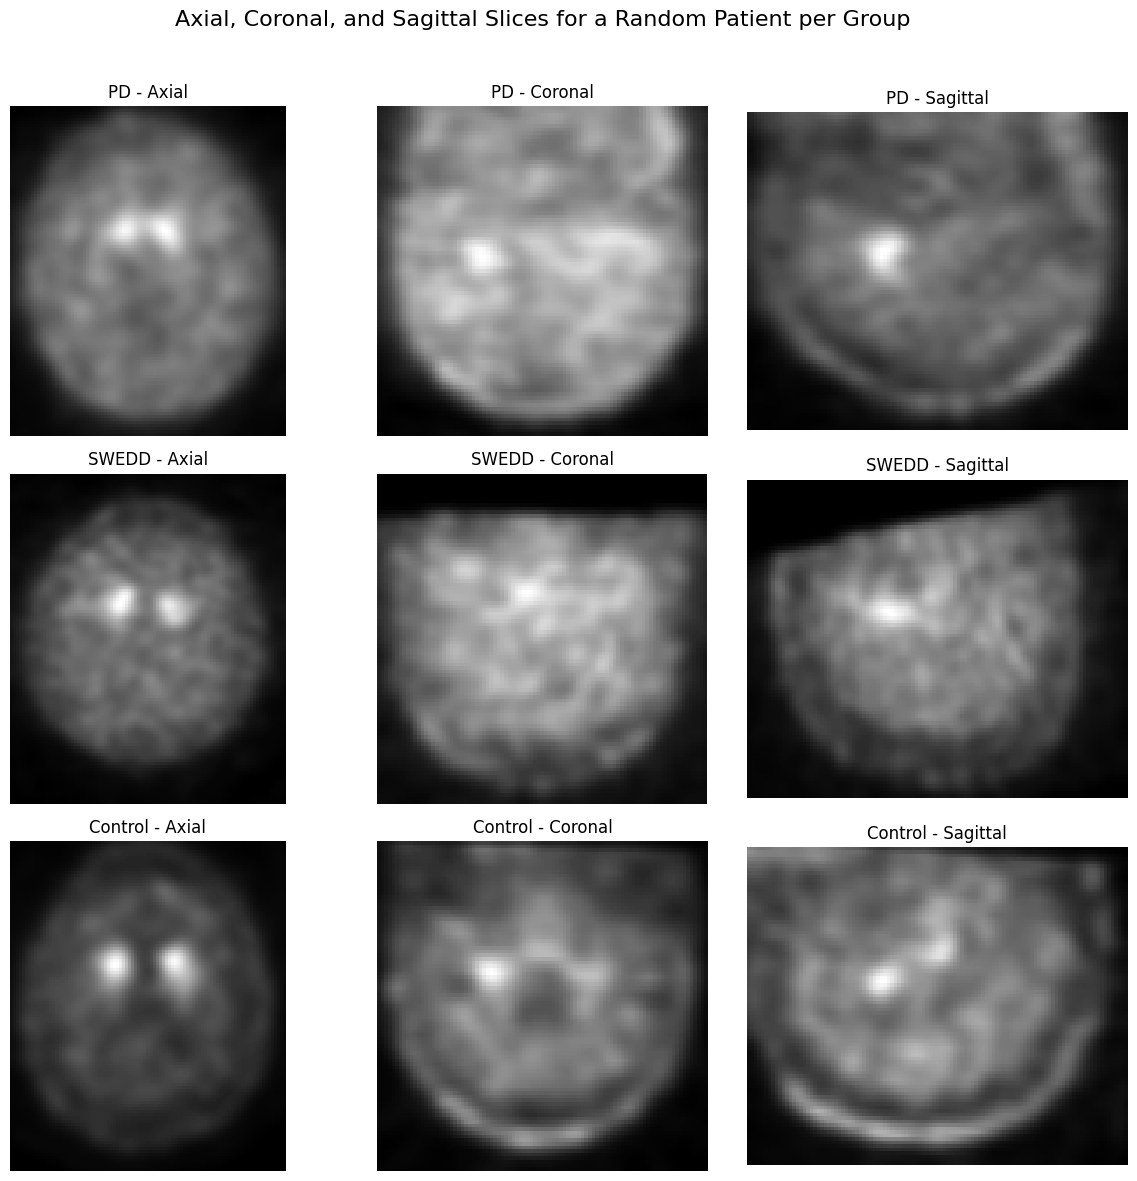

In [8]:
# Cell 6: Data Visualization with GPU Support
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    
    Args:
        volume: 3D numpy array or tensor
    Returns:
        tuple: (axial, coronal, sagittal) slices
    """
    if isinstance(volume, torch.Tensor):
        volume = volume.cpu().numpy()
    
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}

# Set up device for GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue

    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")

    # Load the DICOM volume using the updated load_dicom() function
    volume_tensor, _ = load_dicom(random_file, device)
    
    if volume_tensor is None:
        print(f"Failed to load volume for group {group_label}")
        continue

    # Convert tensor to numpy for visualization
    volume = volume_tensor.cpu().numpy()

    # Verify the volume is 3D
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")

    axial, coronal, sagittal = extract_slices(volume)

    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")

    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")

    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Clean up GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Data Preprocessing

### Intensity Normalization and Volume Preprocessing

### Brain Masking

In [9]:
#!pip install scikit-image

Using device: cuda
Original shape: torch.Size([64, 109, 91])
Processed shape: torch.Size([64, 128, 128])


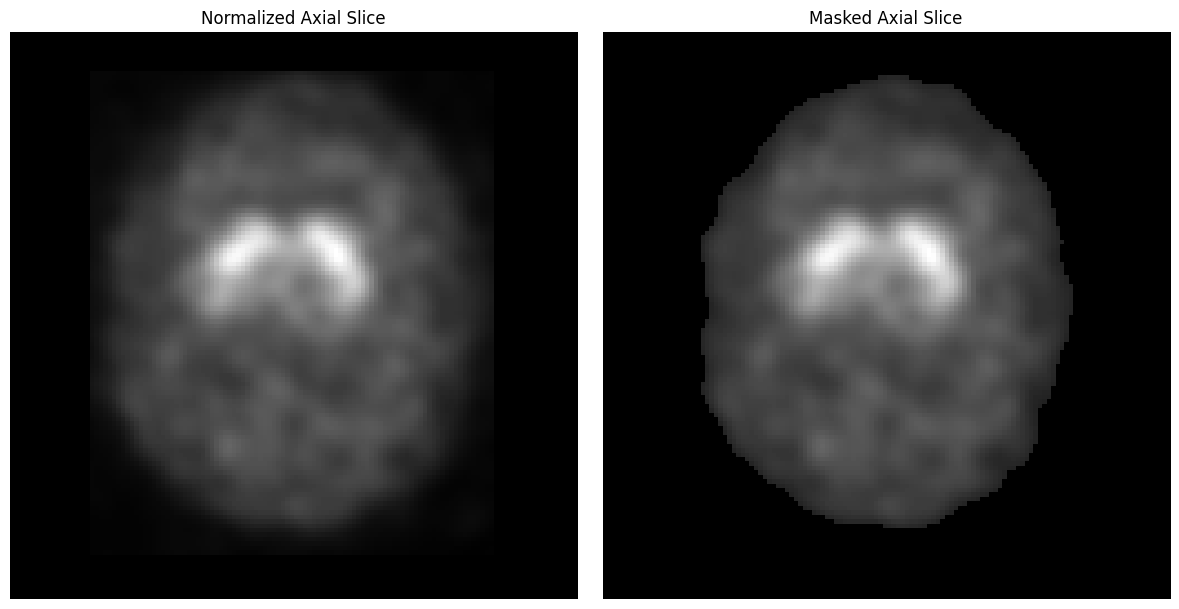

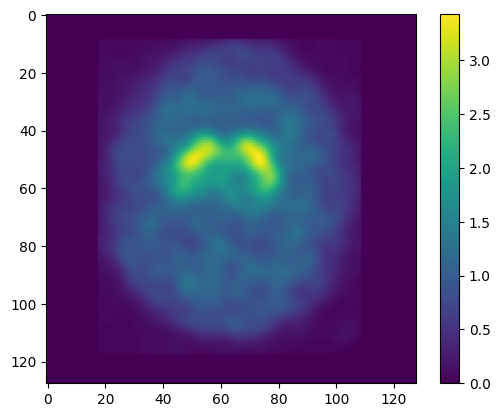

In [10]:
# Cell 7: Data Preprocessing and Brain Masking with GPU Support
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball
import torch

def resize_volume(volume, target_shape=(64, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.
    
    Args:
        volume: Input 3D volume with shape (d, h, w)
        target_shape: Desired output shape as tuple (d_new, h_new, w_new)
    
    Returns:
        Resized volume with shape target_shape
    """
    def get_pad_amounts(current_size, target_size):
        """Helper to calculate padding amounts"""
        if current_size >= target_size:
            return 0, 0
        diff = target_size - current_size
        pad_before = diff // 2
        pad_after = diff - pad_before
        return pad_before, pad_after

    # Convert to numpy if needed
    is_tensor = isinstance(volume, torch.Tensor)
    if is_tensor:
        device = volume.device
        volume = volume.cpu().numpy()

    current_shape = volume.shape
    resized = volume.copy()

    # Calculate padding/cropping for each dimension
    pads = [get_pad_amounts(current_shape[i], target_shape[i]) for i in range(3)]

    # Apply padding if needed
    if any(sum(p) > 0 for p in pads):
        resized = np.pad(
            resized,
            pad_width=pads,
            mode="constant",
            constant_values=0
        )

    # Apply cropping if needed
    for i in range(3):
        if current_shape[i] > target_shape[i]:
            start = (current_shape[i] - target_shape[i]) // 2
            end = start + target_shape[i]
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            else:
                resized = resized[:, :, start:end]

    # Convert back to tensor if input was tensor
    if is_tensor:
        resized = torch.from_numpy(resized).to(device)

    return resized

def process_volume(volume, target_shape=(64, 128, 128), device=None):
    """
    Process a 3D volume:
    1. Normalizing intensity (truncating negatives and min-max scaling)
    2. Resizing to target_shape
    3. Generating a brain mask via Otsu thresholding
    
    Args:
        volume: Input 3D volume (numpy array or torch tensor)
        target_shape: Desired output shape (depth, height, width)
        device: PyTorch device (if None, uses same device as input tensor)
    
    Returns:
        tuple: (norm_vol, mask, masked_vol)
    """
    # Handle input type and device
    is_tensor = isinstance(volume, torch.Tensor)
    if is_tensor:
        device = device or volume.device
        volume = volume.cpu().numpy()

    # 1. Intensity normalization
    volume = volume - volume.min()
    
    # 2. Resize the normalized volume
    norm_vol = resize_volume(volume, target_shape=target_shape)
    
    # Create anatomical mask for normalization
    mask = np.zeros(target_shape, dtype=bool)
    mask[20:40, 82:103, 43:82] = True
    
    # 3. Normalize based on anatomical region
    norm_vol = norm_vol / np.mean(norm_vol[mask])

    # 4. Compute and apply brain mask
    thresh = threshold_otsu(norm_vol)
    final_mask = norm_vol > thresh
    final_mask = binary_closing(final_mask, footprint=ball(2))
    masked_vol = norm_vol * final_mask

    # Convert outputs to tensors if needed
    if is_tensor or device is not None:
        device = device or 'cpu'
        norm_vol = torch.from_numpy(norm_vol).to(device)
        final_mask = torch.from_numpy(final_mask).to(device)
        masked_vol = torch.from_numpy(masked_vol).to(device)

    return norm_vol, final_mask, masked_vol

# Demonstration
if __name__ == "__main__":
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and process a sample file
    sample_file = df.iloc[0]["file_path"]
    original_volume, _ = load_dicom(sample_file, device)
    original_volume = original_volume[9:73,:,:]

    # Process the volume
    norm_vol, mask, masked_vol = process_volume(
        original_volume, 
        target_shape=(64,128,128), 
        device=device
    )

    print(f"Original shape: {original_volume.shape}")
    print(f"Processed shape: {norm_vol.shape}")

    # Extract axial slices for visualization
    axial_norm = norm_vol[norm_vol.shape[0]//2].cpu().numpy()
    axial_masked = masked_vol[masked_vol.shape[0]//2].cpu().numpy()

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(axial_norm, cmap="gray")
    axes[0].set_title("Normalized Axial Slice")
    axes[0].axis("off")

    axes[1].imshow(axial_masked, cmap="gray")
    axes[1].set_title("Masked Axial Slice")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Additional visualization
    plt.figure()
    plt.imshow(norm_vol[32].cpu().numpy())
    plt.colorbar()
    plt.show()

## Dataloader Creation (with Shape Validation)

In [11]:
#!pip install ipywidgets
import importlib
import dataset_utils
importlib.reload(dataset_utils)


<module 'dataset_utils' from 'c:\\Users\\alexc\\GitHubRepos\\ParkinsonThesis\\dataset_utils.py'>

Using device: cuda


100%|██████████| 10/10 [00:00<00:00, 17.78it/s]


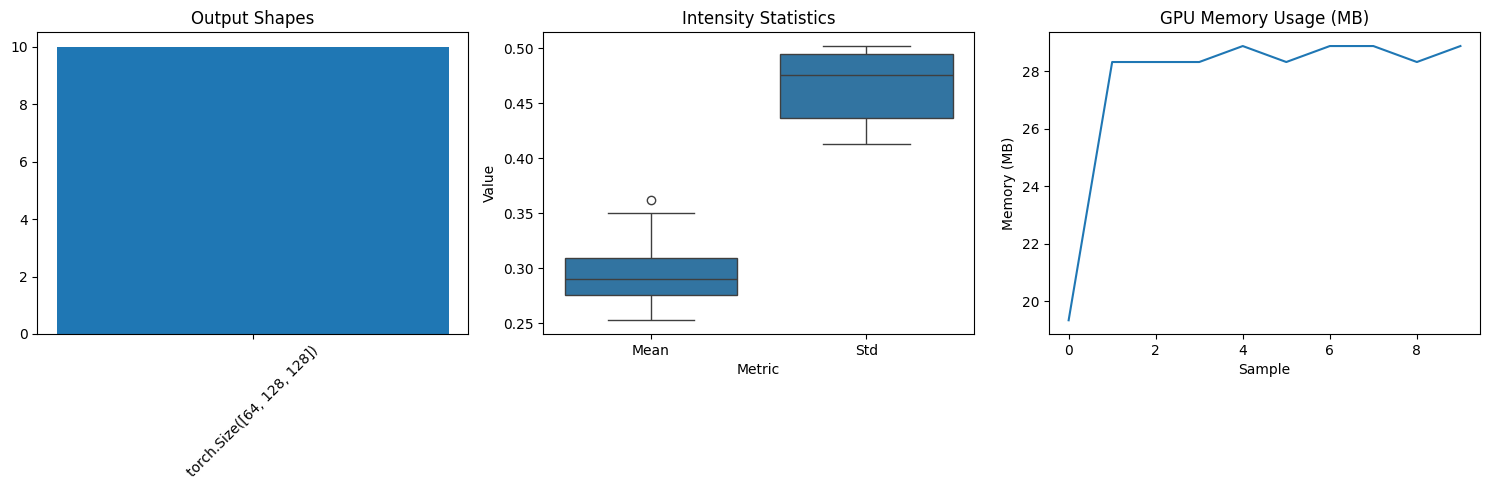


Validation Summary:
Processed 10 samples successfully
All shapes identical: True
Target shape achieved: True

Intensity Statistics:
Mean intensity: 0.299 (±0.033)
Mean std: 0.465 (±0.032)


In [12]:
# Cell 8: Pipeline Validation and Quality Checks
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

def validate_pipeline(df, num_samples=10):
    """
    Validates the entire pipeline by checking:
    1. Slice dimensions
    2. GPU tensor operations
    3. Intensity distributions
    4. Memory usage
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Statistics collectors
    shapes = []
    intensities = []
    memory_usage = []
    
    # Sample files
    sample_files = df.sample(n=min(num_samples, len(df)))
    
    for _, row in tqdm(sample_files.iterrows(), total=len(sample_files)):
        # Load and process volume
        volume_tensor, _ = load_dicom(row['file_path'], device)
        
        if volume_tensor is None:
            print(f"Failed to load {row['file_path']}")
            continue
            
        # Record initial GPU memory
        if torch.cuda.is_available():
            memory_usage.append(torch.cuda.memory_allocated() / 1024**2)  # MB
            
        # Process volume
        norm_vol, mask, masked_vol = process_volume(
            volume_tensor[9:73],  # Extract required slices
            target_shape=(64, 128, 128),
            device=device
        )
        
        # Record shape
        shapes.append(masked_vol.shape)
        
        # Record intensity statistics
        intensities.append({
            'mean': masked_vol.mean().item(),
            'std': masked_vol.std().item(),
            'min': masked_vol.min().item(),
            'max': masked_vol.max().item()
        })
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Shape verification
    plt.subplot(131)
    shape_counts = {}
    for s in shapes:
        shape_counts[str(s)] = shape_counts.get(str(s), 0) + 1
    plt.bar(shape_counts.keys(), shape_counts.values())
    plt.title('Output Shapes')
    plt.xticks(rotation=45)
    
    # Plot 2: Intensity distribution
    plt.subplot(132)
    # Create DataFrame for seaborn boxplot
    intensity_data = []
    for i in intensities:
        intensity_data.extend([
            {'Metric': 'Mean', 'Value': i['mean']},
            {'Metric': 'Std', 'Value': i['std']}
        ])
    intensity_df = pd.DataFrame(intensity_data)
    sns.boxplot(data=intensity_df, x='Metric', y='Value')
    plt.title('Intensity Statistics')
    
    # Plot 3: Memory usage
    if memory_usage:
        plt.subplot(133)
        plt.plot(memory_usage)
        plt.title('GPU Memory Usage (MB)')
        plt.xlabel('Sample')
        plt.ylabel('Memory (MB)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nValidation Summary:")
    print(f"Processed {len(shapes)} samples successfully")
    print(f"All shapes identical: {len(set(str(s) for s in shapes)) == 1}")
    print(f"Target shape achieved: {all(s == (64, 128, 128) for s in shapes)}")
    
    # Print intensity statistics
    print("\nIntensity Statistics:")
    means = [i['mean'] for i in intensities]
    stds = [i['std'] for i in intensities]
    print(f"Mean intensity: {np.mean(means):.3f} (±{np.std(means):.3f})")
    print(f"Mean std: {np.mean(stds):.3f} (±{np.std(stds):.3f})")
    
    return shapes, intensities, memory_usage

# Run validation
df = pd.read_csv("validated_file_paths.csv")
shapes, intensities, memory_usage = validate_pipeline(df)

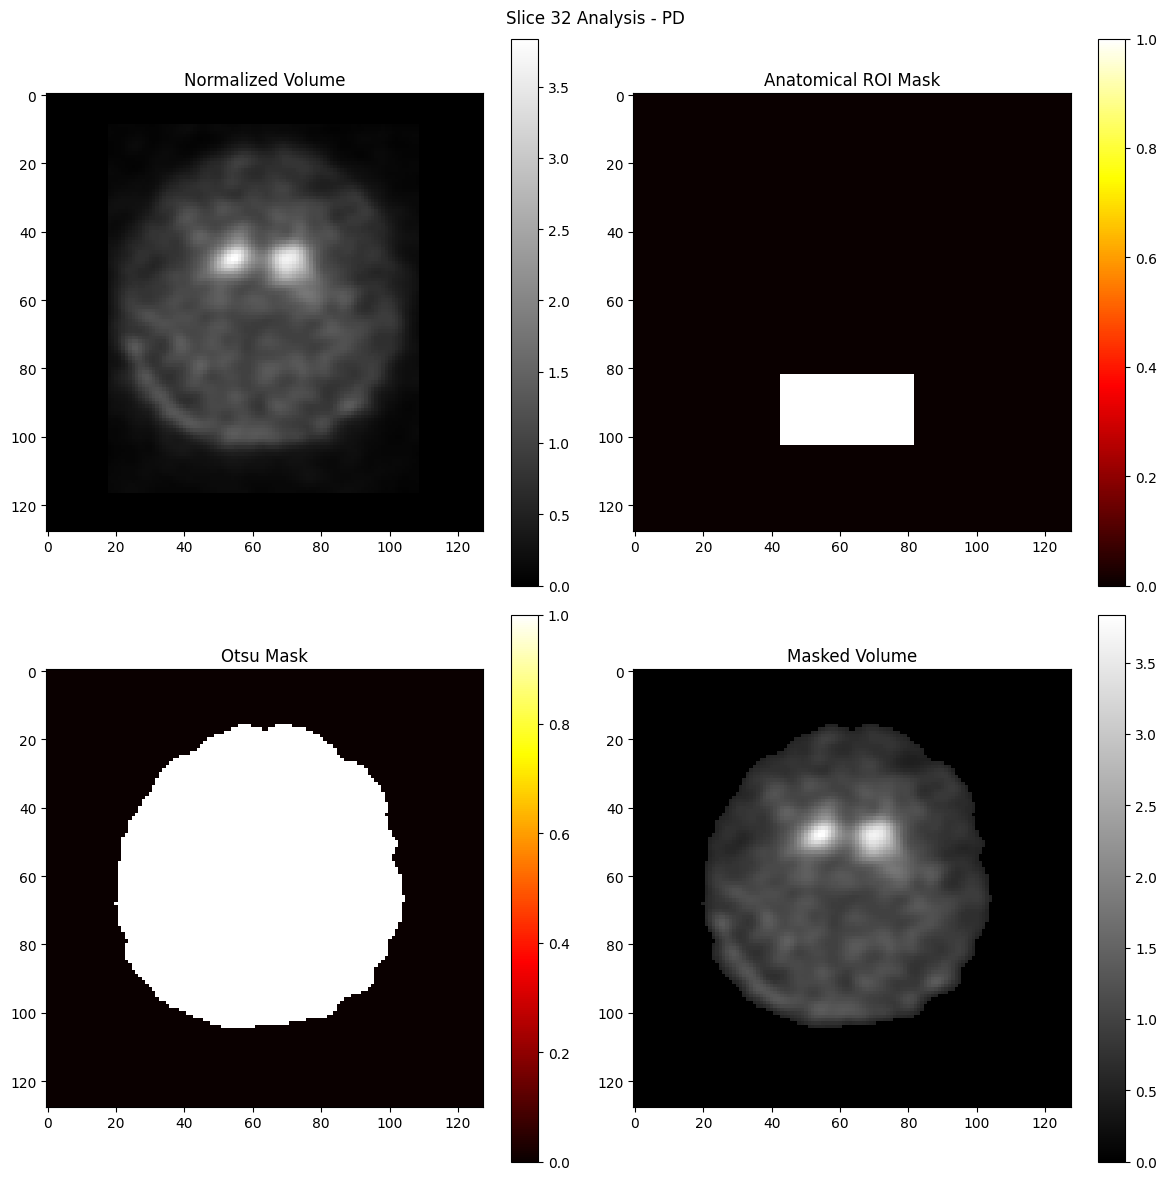

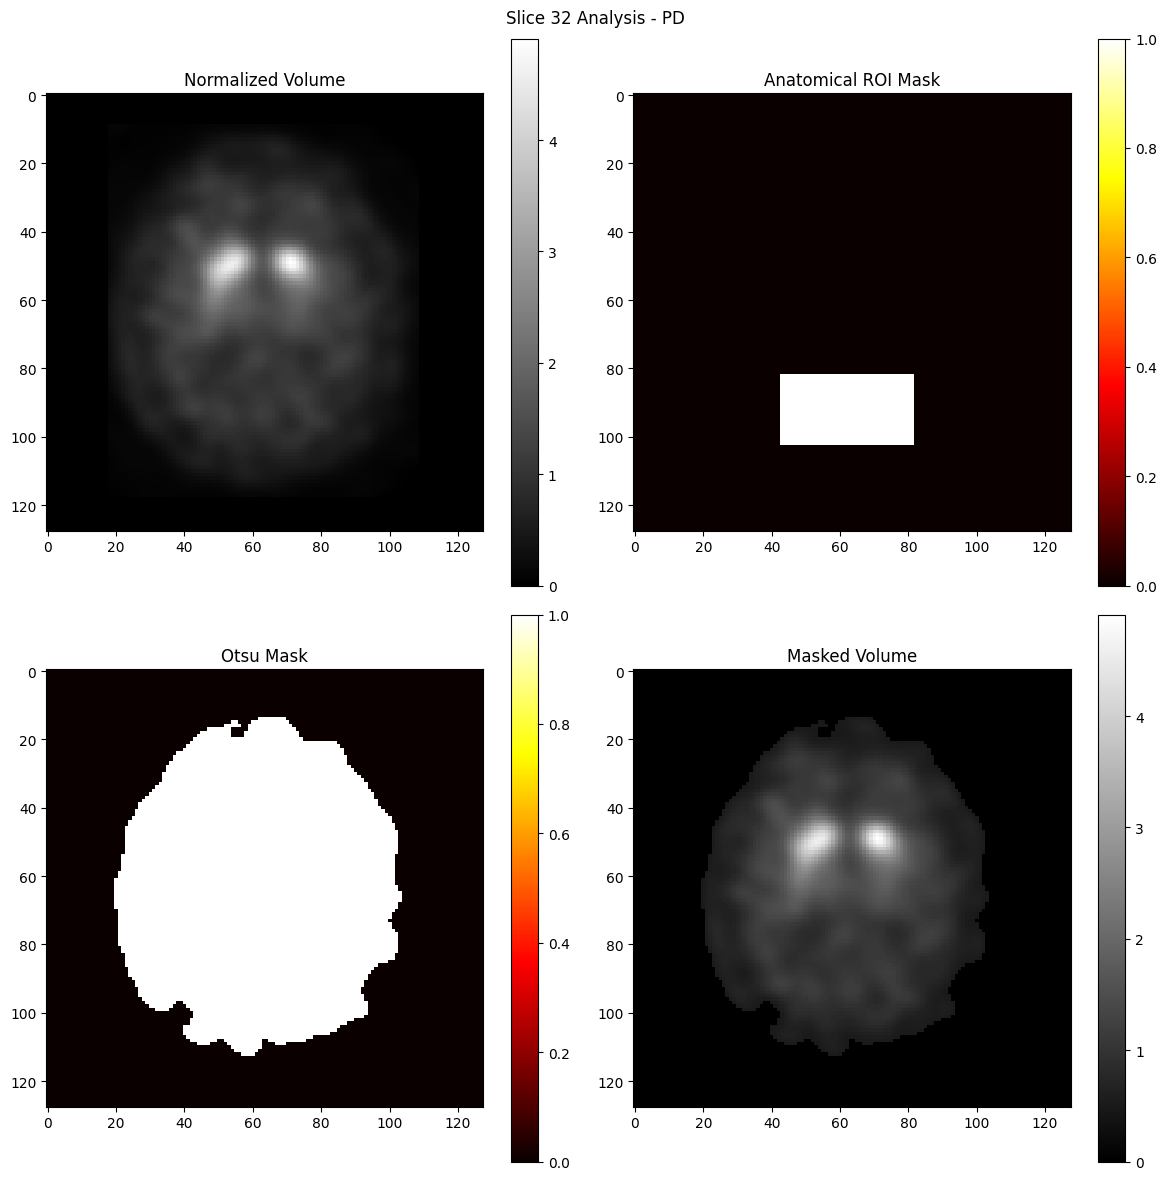

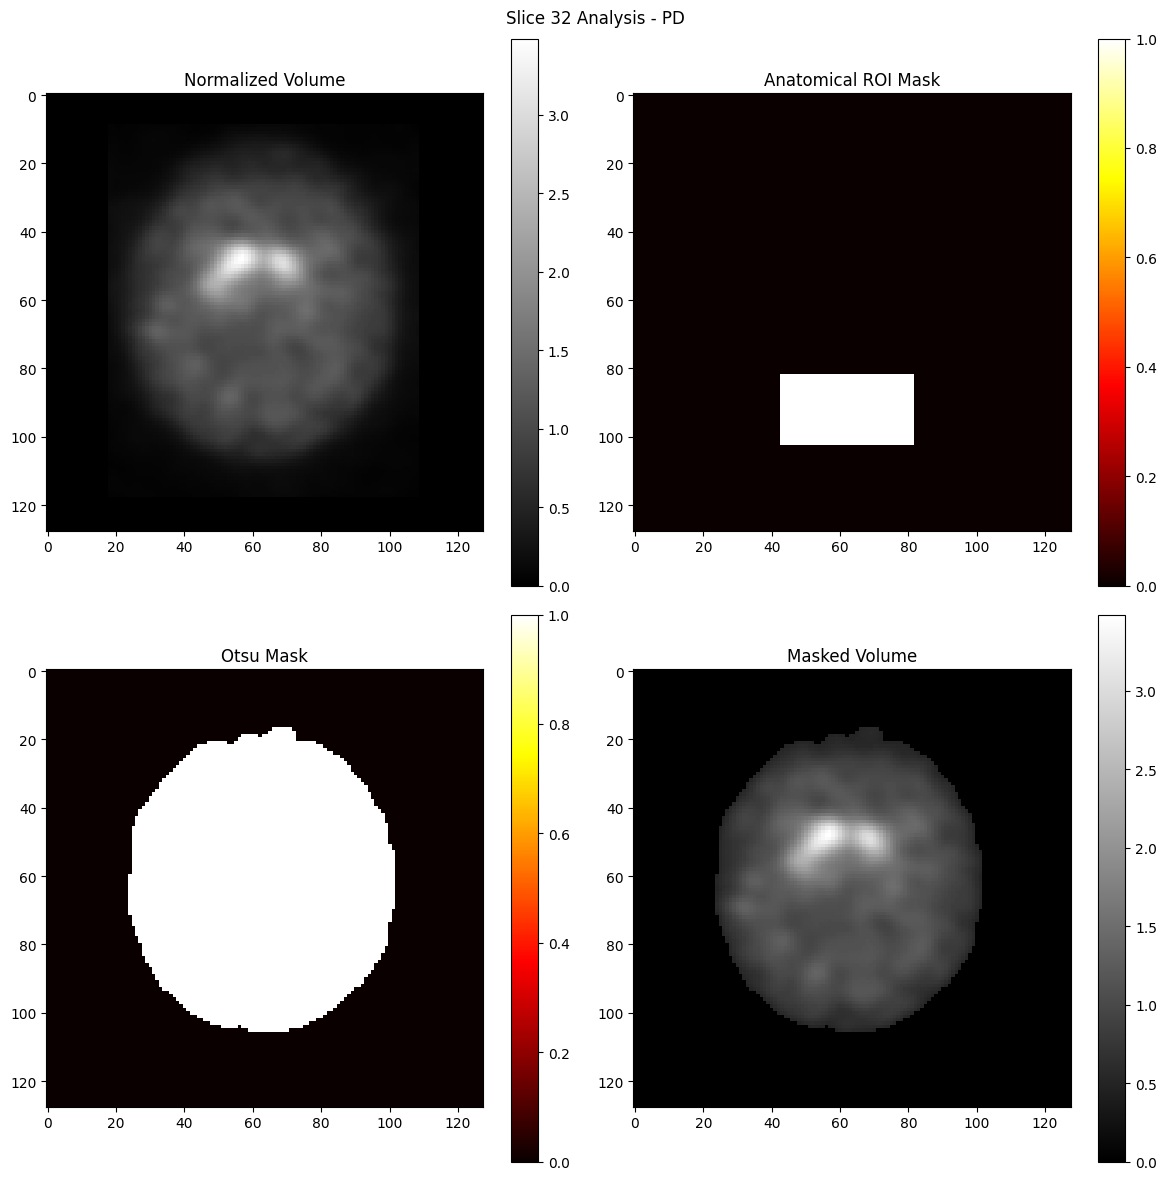

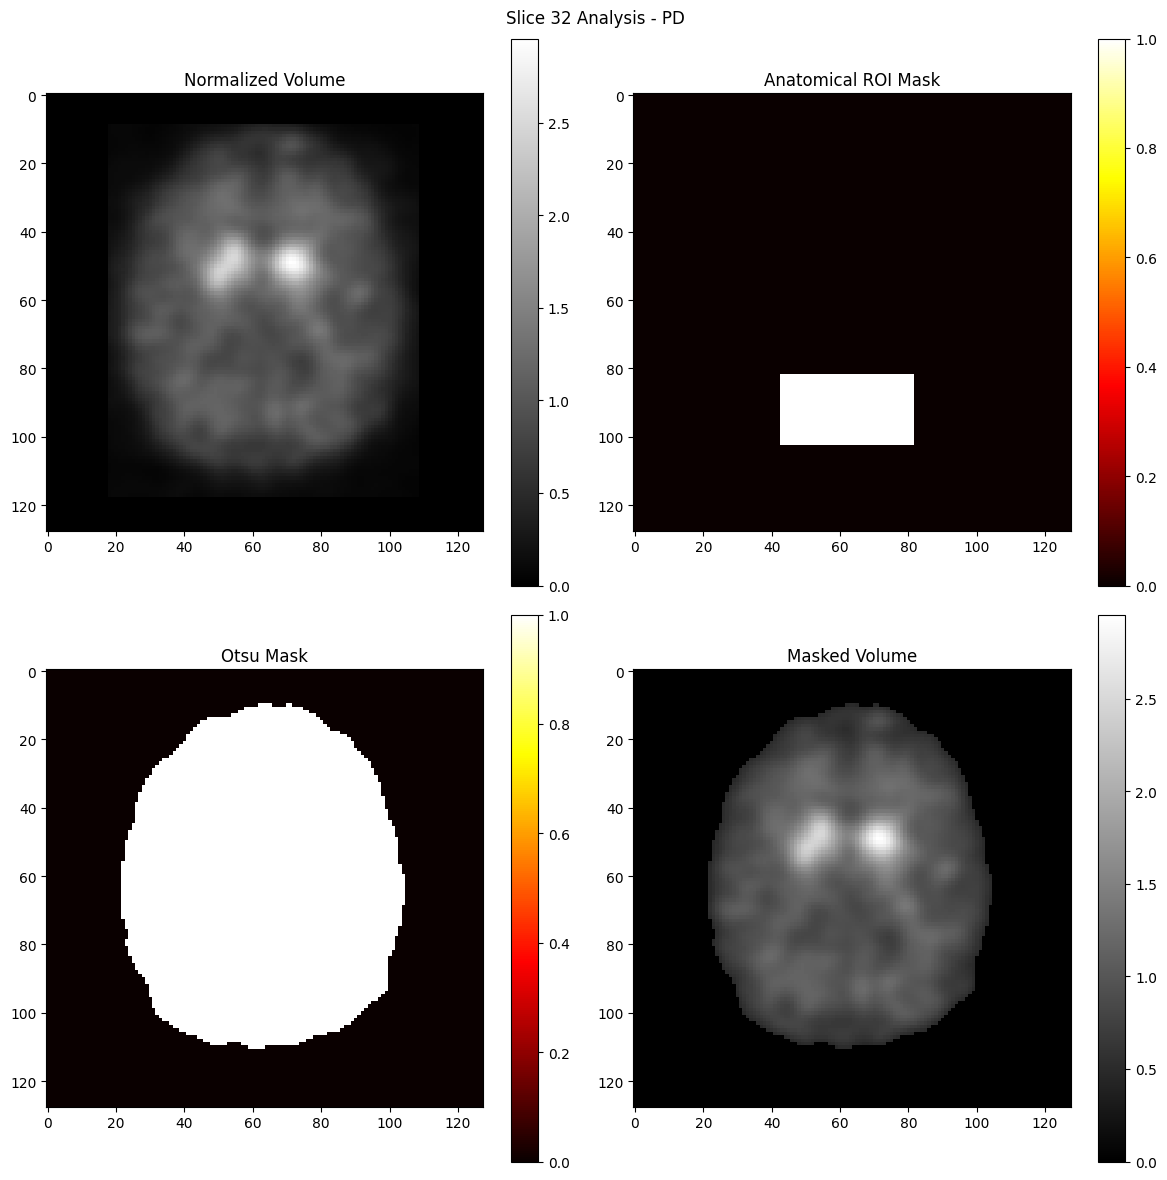

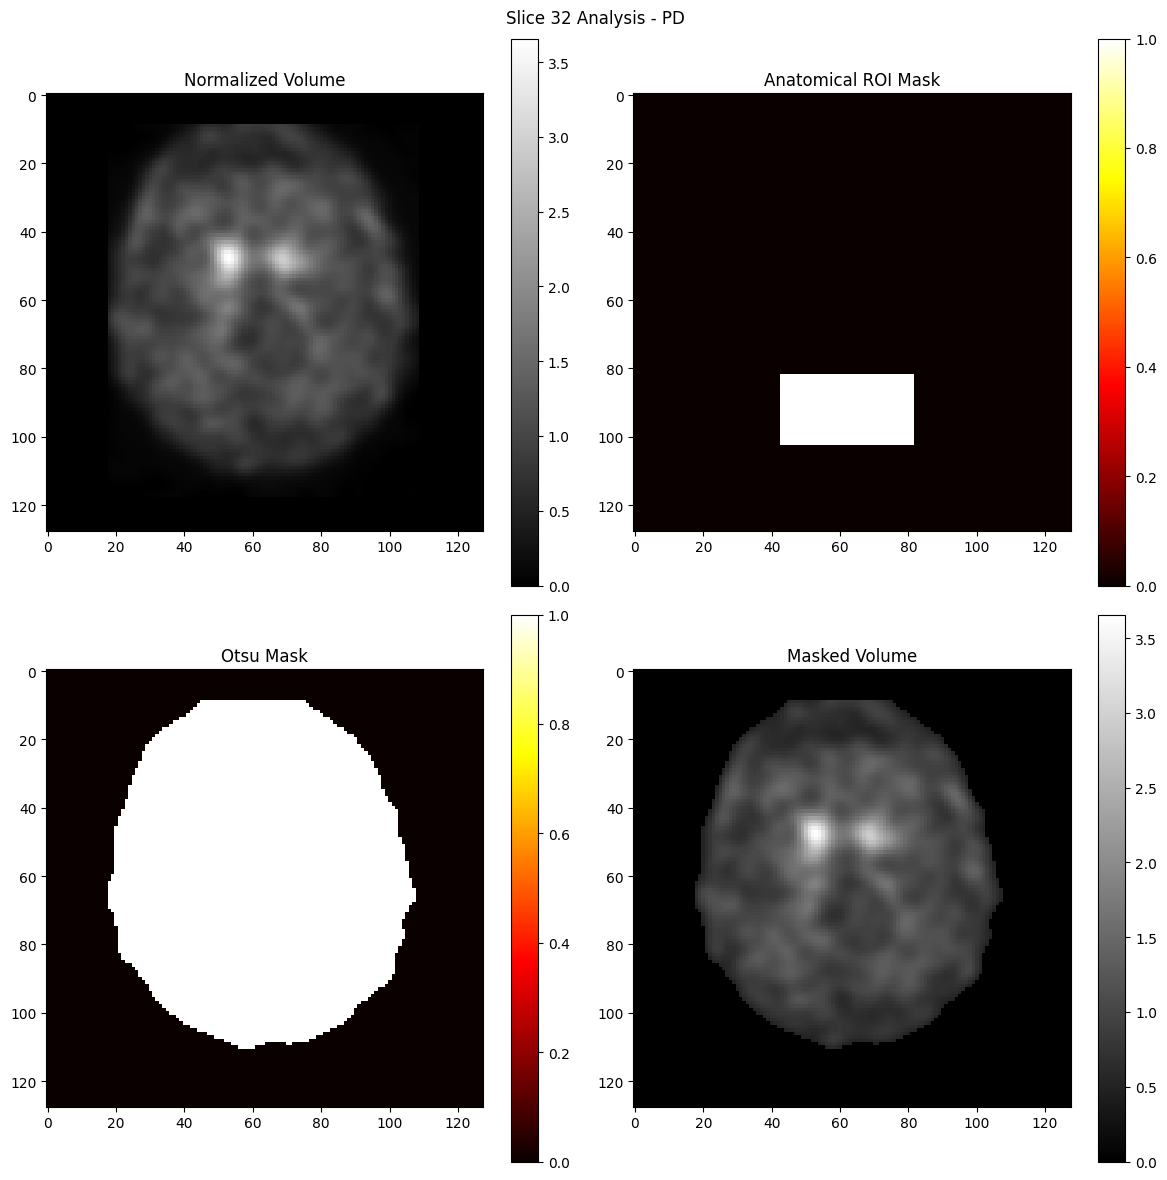

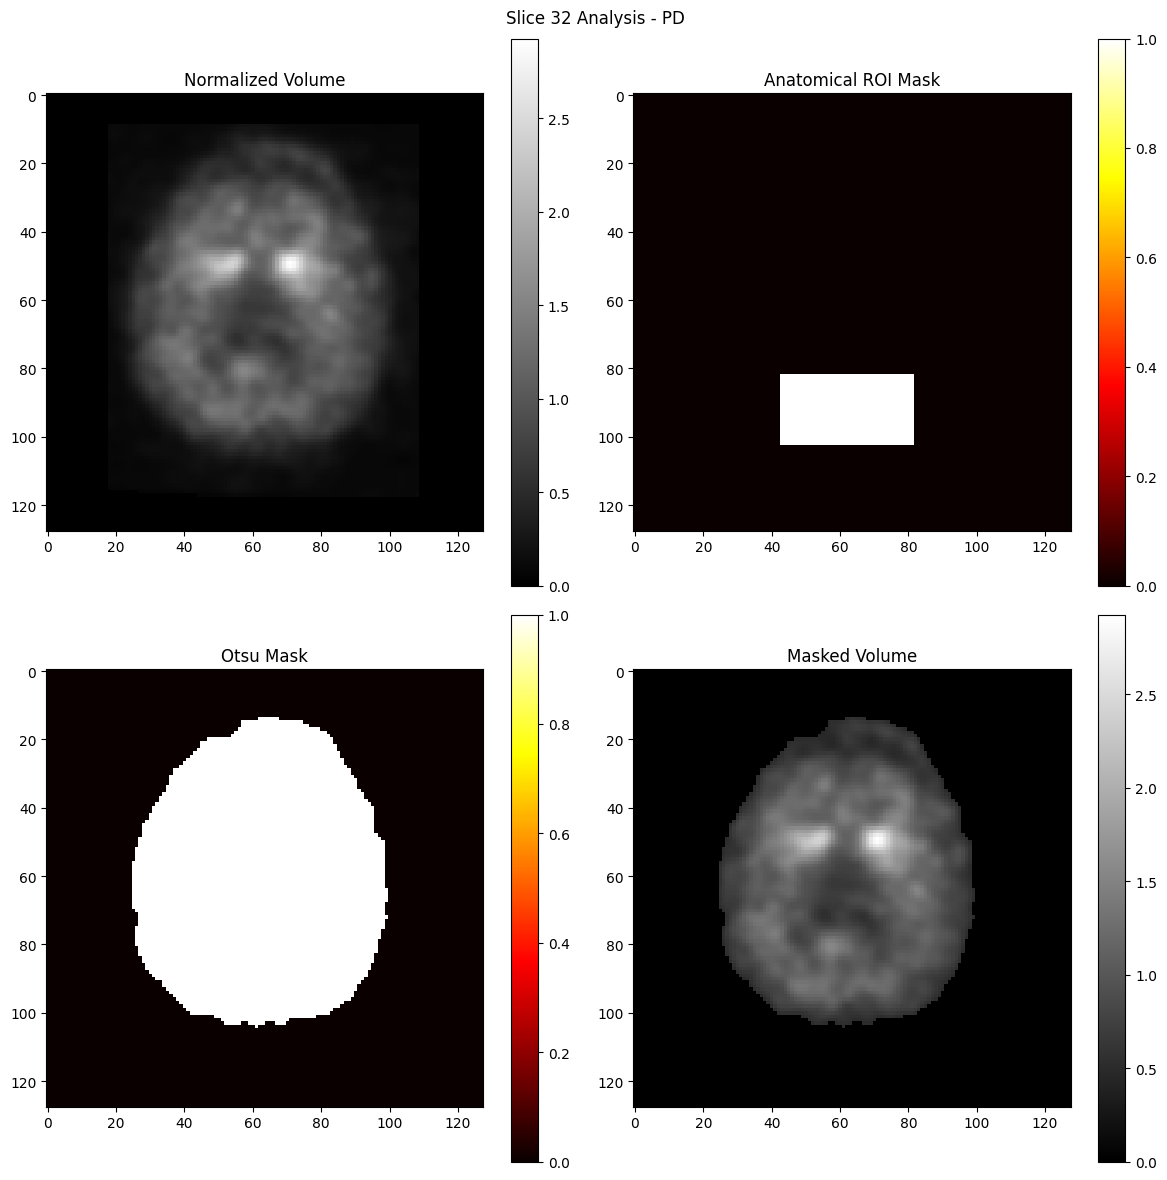

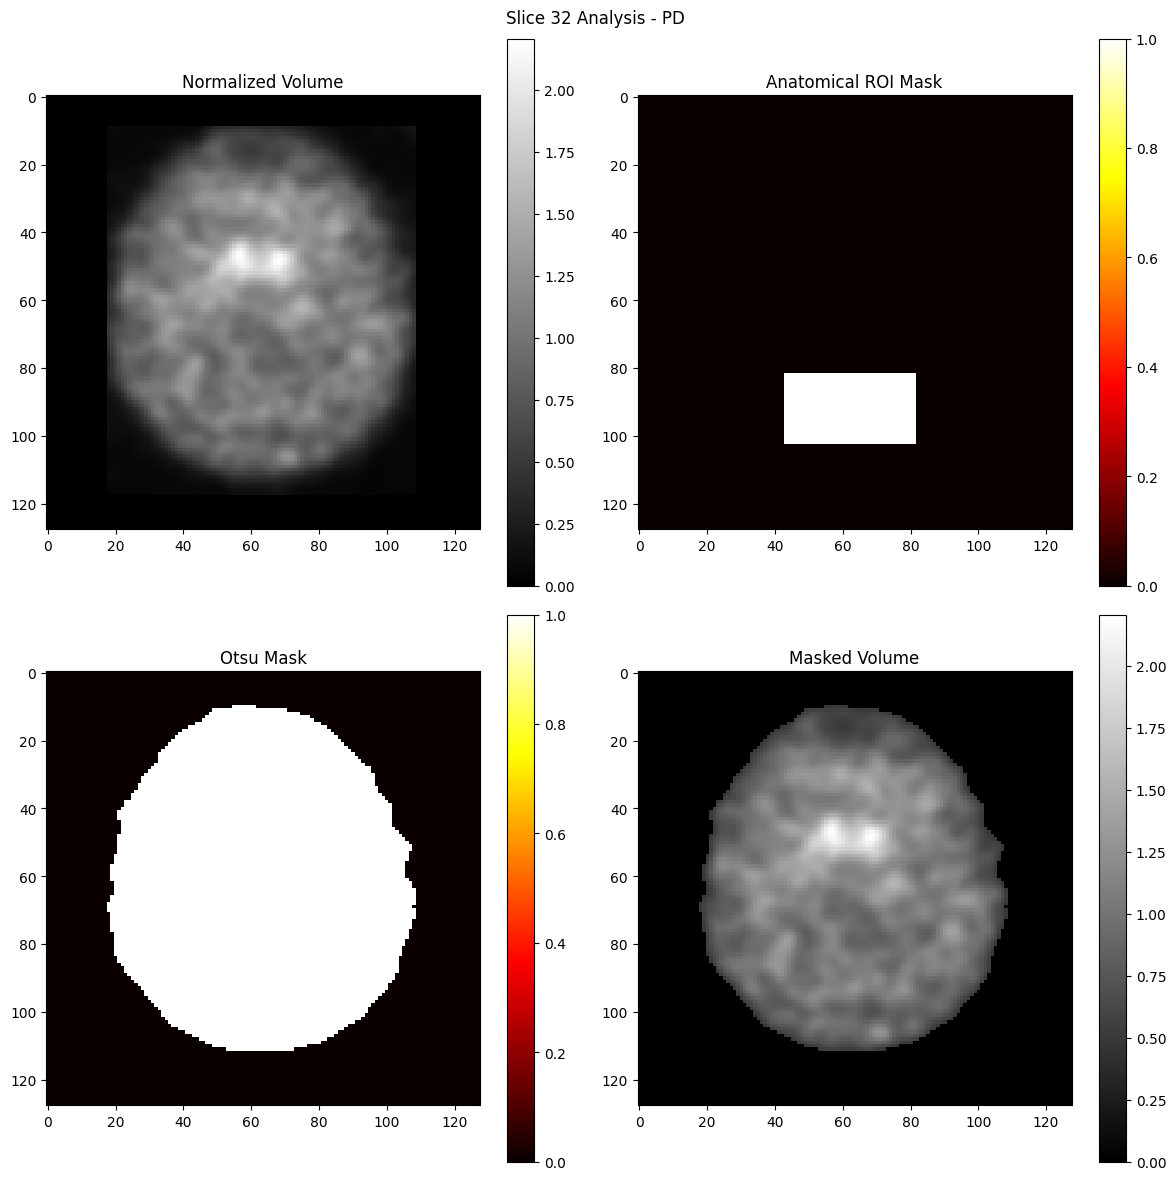

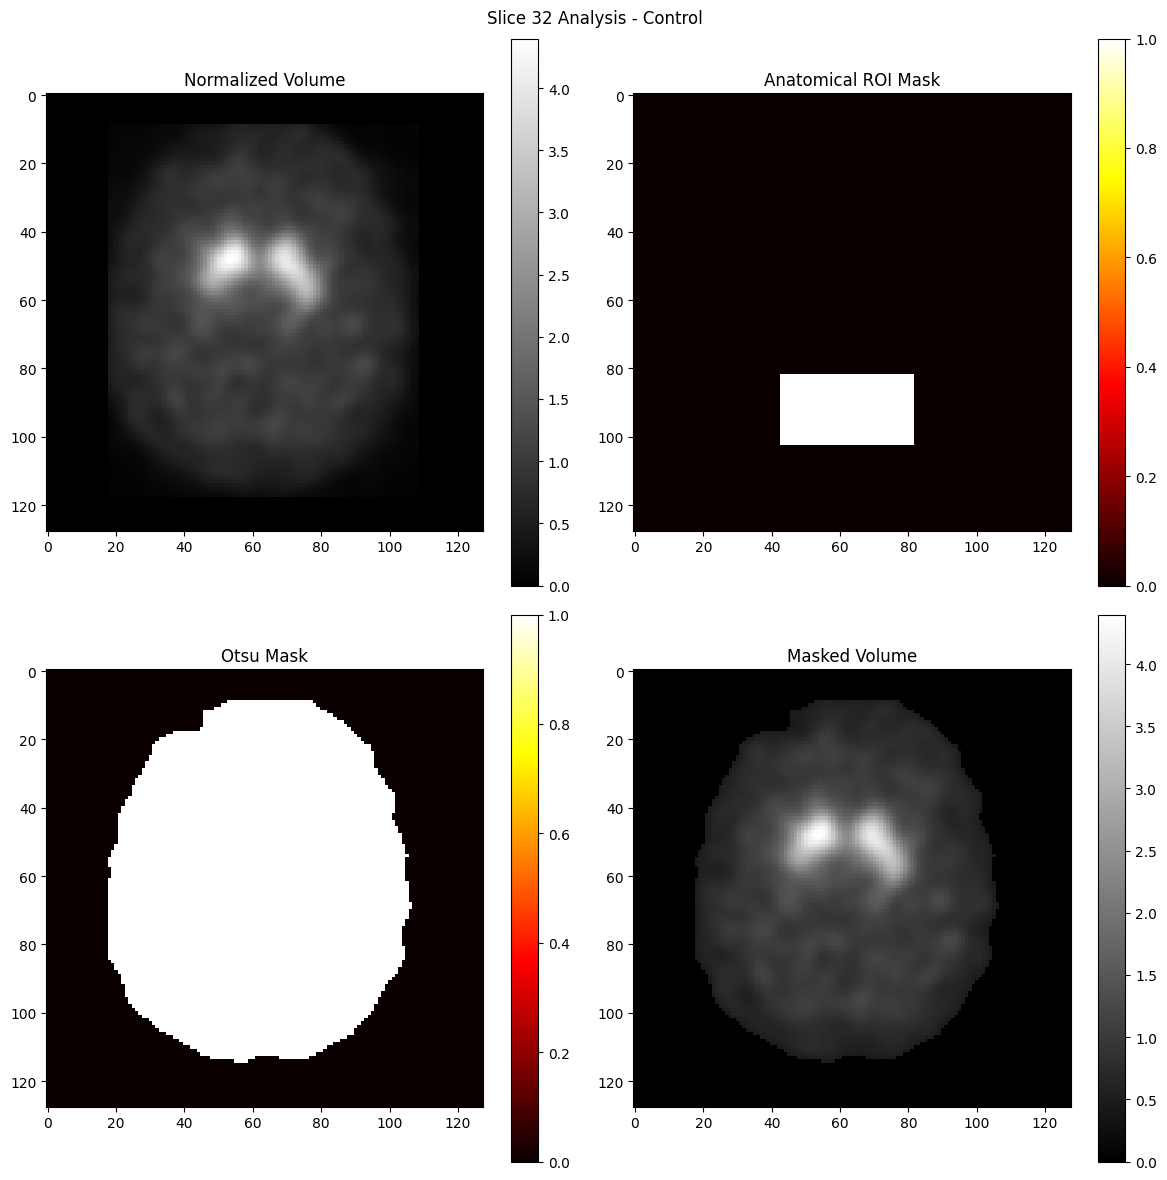

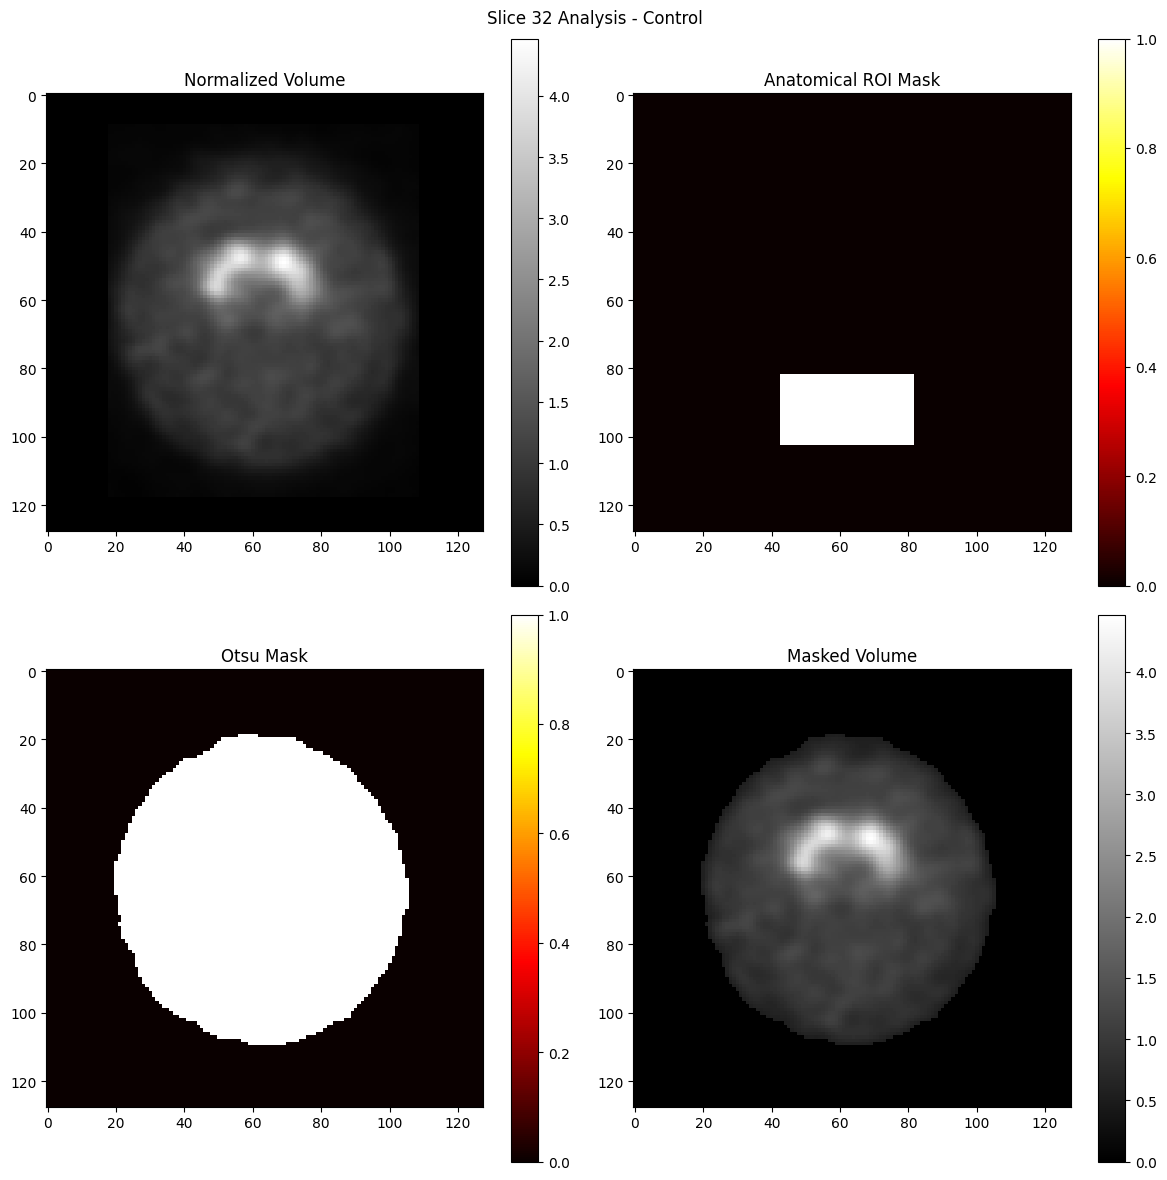

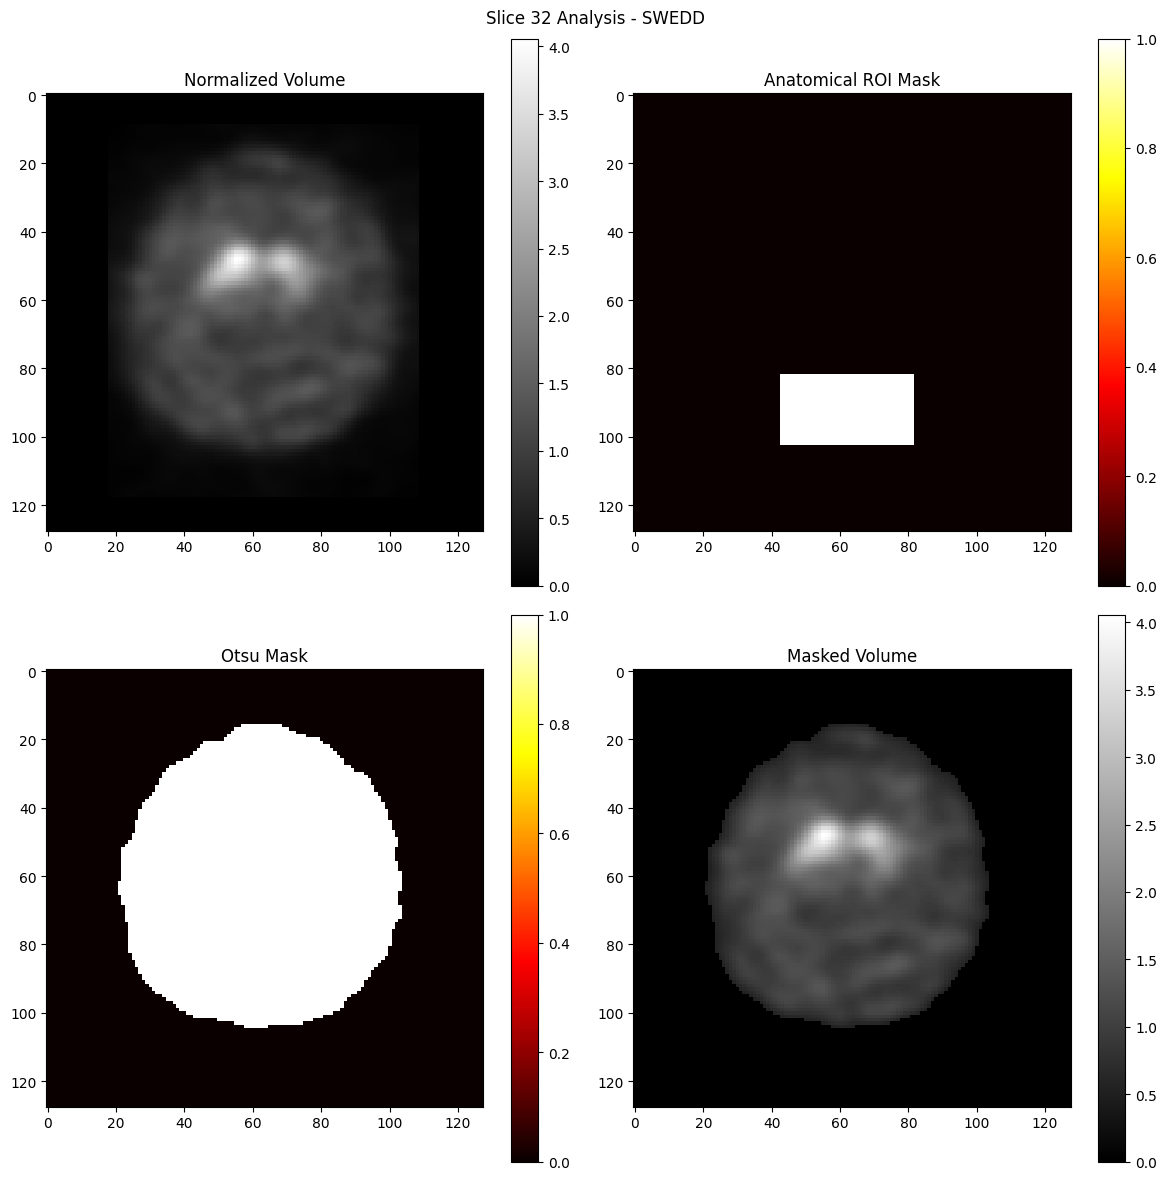

In [13]:
# Cell 9: Validate Masking and ROI Selection
def validate_masking(df, num_samples=10):
    """
    Validates the masking process by visualizing:
    1. Original volume
    2. Anatomical ROI mask
    3. Otsu mask
    4. Final masked volume
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Sample files
    sample_files = df.sample(n=min(num_samples, len(df)))
    
    for _, row in sample_files.iterrows():
        # Load volume
        volume_tensor, _ = load_dicom(row['file_path'], device)
        if volume_tensor is None:
            continue
            
        # Extract slices and process
        volume = volume_tensor[9:73]
        norm_vol, mask, masked_vol = process_volume(
            volume,
            target_shape=(64, 128, 128),
            device=device
        )
        
        # Create anatomical ROI mask
        roi_mask = torch.zeros_like(norm_vol, device=device)
        roi_mask[20:40, 82:103, 43:82] = 1
        
        # Plot middle slices
        mid_slice = norm_vol.shape[0] // 2
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        fig.suptitle(f"Slice {mid_slice} Analysis - {row['label']}")
        
        # Original normalized volume
        im0 = axes[0, 0].imshow(norm_vol[mid_slice].cpu().numpy(), cmap='gray')
        axes[0, 0].set_title('Normalized Volume')
        plt.colorbar(im0, ax=axes[0, 0])
        
        # ROI mask
        im1 = axes[0, 1].imshow(roi_mask[mid_slice].cpu().numpy(), cmap='hot')
        axes[0, 1].set_title('Anatomical ROI Mask')
        plt.colorbar(im1, ax=axes[0, 1])
        
        # Otsu mask
        im2 = axes[1, 0].imshow(mask[mid_slice].cpu().numpy(), cmap='hot')
        axes[1, 0].set_title('Otsu Mask')
        plt.colorbar(im2, ax=axes[1, 0])
        
        # Final masked volume
        im3 = axes[1, 1].imshow(masked_vol[mid_slice].cpu().numpy(), cmap='gray')
        axes[1, 1].set_title('Masked Volume')
        plt.colorbar(im3, ax=axes[1, 1])
        
        plt.tight_layout()
        plt.show()
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Run masking validation
validate_masking(df)

Running CPU benchmark...
Running GPU benchmark...


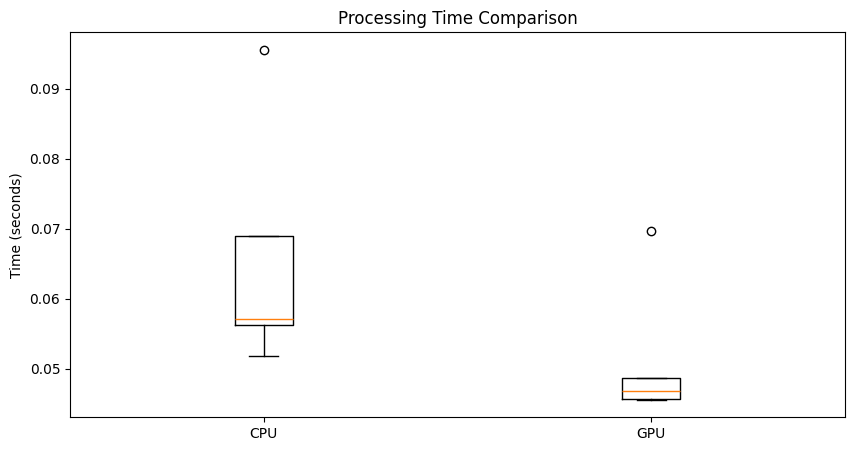


Benchmark Summary:
CPU mean time: 0.066s (±0.016s)
GPU mean time: 0.051s (±0.009s)
Speedup: 1.29x

GPU Operation Profile:
------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   sample_processing         0.00%       0.000us         0.00%       0.000us       0.000us      40.761ms      4677.48%      40.761ms      40.761ms        

In [13]:
# Cell 10: GPU Performance Benchmarking
import time
from torch.profiler import profile, record_function, ProfilerActivity

def benchmark_pipeline(df, num_samples=5):
    """
    Benchmarks the pipeline comparing CPU vs GPU operations
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_files = df.sample(n=min(num_samples, len(df)))
    
    def process_batch(files, use_gpu=True):
        target_device = device if use_gpu else torch.device('cpu')
        times = []
        
        for _, row in files.iterrows():
            start = time.time()
            
            # Load and process
            volume_tensor, _ = load_dicom(row['file_path'], target_device)
            if volume_tensor is not None:
                volume = volume_tensor[9:73]
                norm_vol, mask, masked_vol = process_volume(
                    volume,
                    target_shape=(64, 128, 128),
                    device=target_device
                )
            
            end = time.time()
            times.append(end - start)
            
            # Clear GPU memory
            if use_gpu and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return times
    
    # Benchmark CPU
    print("Running CPU benchmark...")
    cpu_times = process_batch(sample_files, use_gpu=False)
    
    # Benchmark GPU
    print("Running GPU benchmark...")
    gpu_times = process_batch(sample_files, use_gpu=True)
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.boxplot([cpu_times, gpu_times], labels=['CPU', 'GPU'])
    plt.title('Processing Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.show()
    
    # Print summary
    print("\nBenchmark Summary:")
    print(f"CPU mean time: {np.mean(cpu_times):.3f}s (±{np.std(cpu_times):.3f}s)")
    print(f"GPU mean time: {np.mean(gpu_times):.3f}s (±{np.std(gpu_times):.3f}s)")
    print(f"Speedup: {np.mean(cpu_times)/np.mean(gpu_times):.2f}x")
    
    # Profile GPU operations
    if torch.cuda.is_available():
        print("\nGPU Operation Profile:")
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                    profile_memory=True, record_shapes=True) as prof:
            with record_function("sample_processing"):
                # Process one sample
                sample_row = sample_files.iloc[0]
                volume_tensor, _ = load_dicom(sample_row['file_path'], device)
                if volume_tensor is not None:
                    volume = volume_tensor[9:73]
                    norm_vol, mask, masked_vol = process_volume(
                        volume,
                        target_shape=(64, 128, 128),
                        device=device
                    )
        
        print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

# Run benchmark
benchmark_pipeline(df)

# Exploratory Data Analysis (EDA)

Processing Control: 30it [00:02, 12.10it/s]
Processing PD: 30it [00:03,  8.20it/s]
Processing SWEDD: 30it [00:06,  4.91it/s]


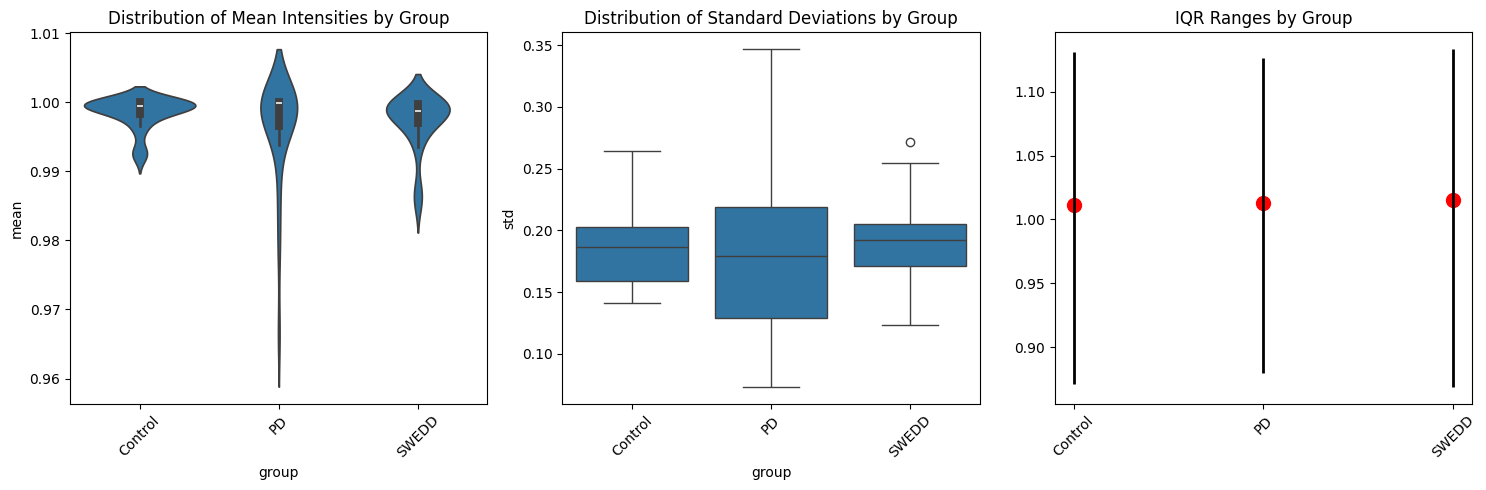


Summary Statistics by Group:
          mean        median    std
          mean    std   mean   mean
group                              
Control  0.999  0.002  1.011  0.188
PD       0.996  0.008  1.013  0.186
SWEDD    0.997  0.004  1.016  0.192


In [14]:
# Cell 11: Group-wise Intensity Distribution Analysis
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_group_intensities(df, num_samples_per_group=30):
    """
    Analyzes intensity distributions across patient groups
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Prepare data collection
    intensity_data = []
    
    # Sample equal numbers from each group
    for group in ['Control', 'PD', 'SWEDD']:
        group_df = df[df['label'] == group]
        n_samples = min(num_samples_per_group, len(group_df))
        samples = group_df.sample(n=n_samples)
        
        for _, row in tqdm(samples.iterrows(), desc=f"Processing {group}"):
            volume_tensor, _ = load_dicom(row['file_path'], device)
            if volume_tensor is None:
                continue
                
            # Process volume
            norm_vol, mask, masked_vol = process_volume(
                volume_tensor[9:73],
                target_shape=(64, 128, 128),
                device=device
            )
            
            # Calculate statistics for anatomical ROI
            roi_mask = torch.zeros_like(norm_vol, device=device)
            roi_mask[20:40, 82:103, 43:82] = 1
            roi_values = masked_vol[roi_mask.bool()]
            
            # Collect metrics
            metrics = {
                'group': group,
                'mean': roi_values.mean().item(),
                'median': roi_values.median().item(),
                'std': roi_values.std().item(),
                'q25': roi_values.quantile(0.25).item(),
                'q75': roi_values.quantile(0.75).item()
            }
            intensity_data.append(metrics)
            
            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Convert to DataFrame
    intensity_df = pd.DataFrame(intensity_data)
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Violin plots
    plt.subplot(131)
    sns.violinplot(data=intensity_df, x='group', y='mean', inner='box')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xticks(rotation=45)
    
    # Plot 2: Box plots with outliers
    plt.subplot(132)
    sns.boxplot(data=intensity_df, x='group', y='std')
    plt.title('Distribution of Standard Deviations by Group')
    plt.xticks(rotation=45)
    
    # Plot 3: IQR ranges
    plt.subplot(133)
    for i, group in enumerate(intensity_df['group'].unique()):
        group_data = intensity_df[intensity_df['group'] == group]
        plt.vlines(x=i, ymin=group_data['q25'].mean(), ymax=group_data['q75'].mean(), 
                  color='black', linewidth=2)
        plt.scatter(i, group_data['median'].mean(), color='red', s=100)
    plt.xticks(range(len(intensity_df['group'].unique())), 
               intensity_df['group'].unique(), rotation=45)
    plt.title('IQR Ranges by Group')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics by Group:")
    print(intensity_df.groupby('group').agg({
        'mean': ['mean', 'std'],
        'median': 'mean',
        'std': 'mean',
    }).round(3))
    
    return intensity_df

# Run analysis
df = pd.read_csv("validated_file_paths.csv")
intensity_results = analyze_group_intensities(df)

Processing Control: 10it [00:00, 17.87it/s]
Processing PD: 10it [00:00, 15.35it/s]
Processing SWEDD: 10it [00:00, 13.05it/s]


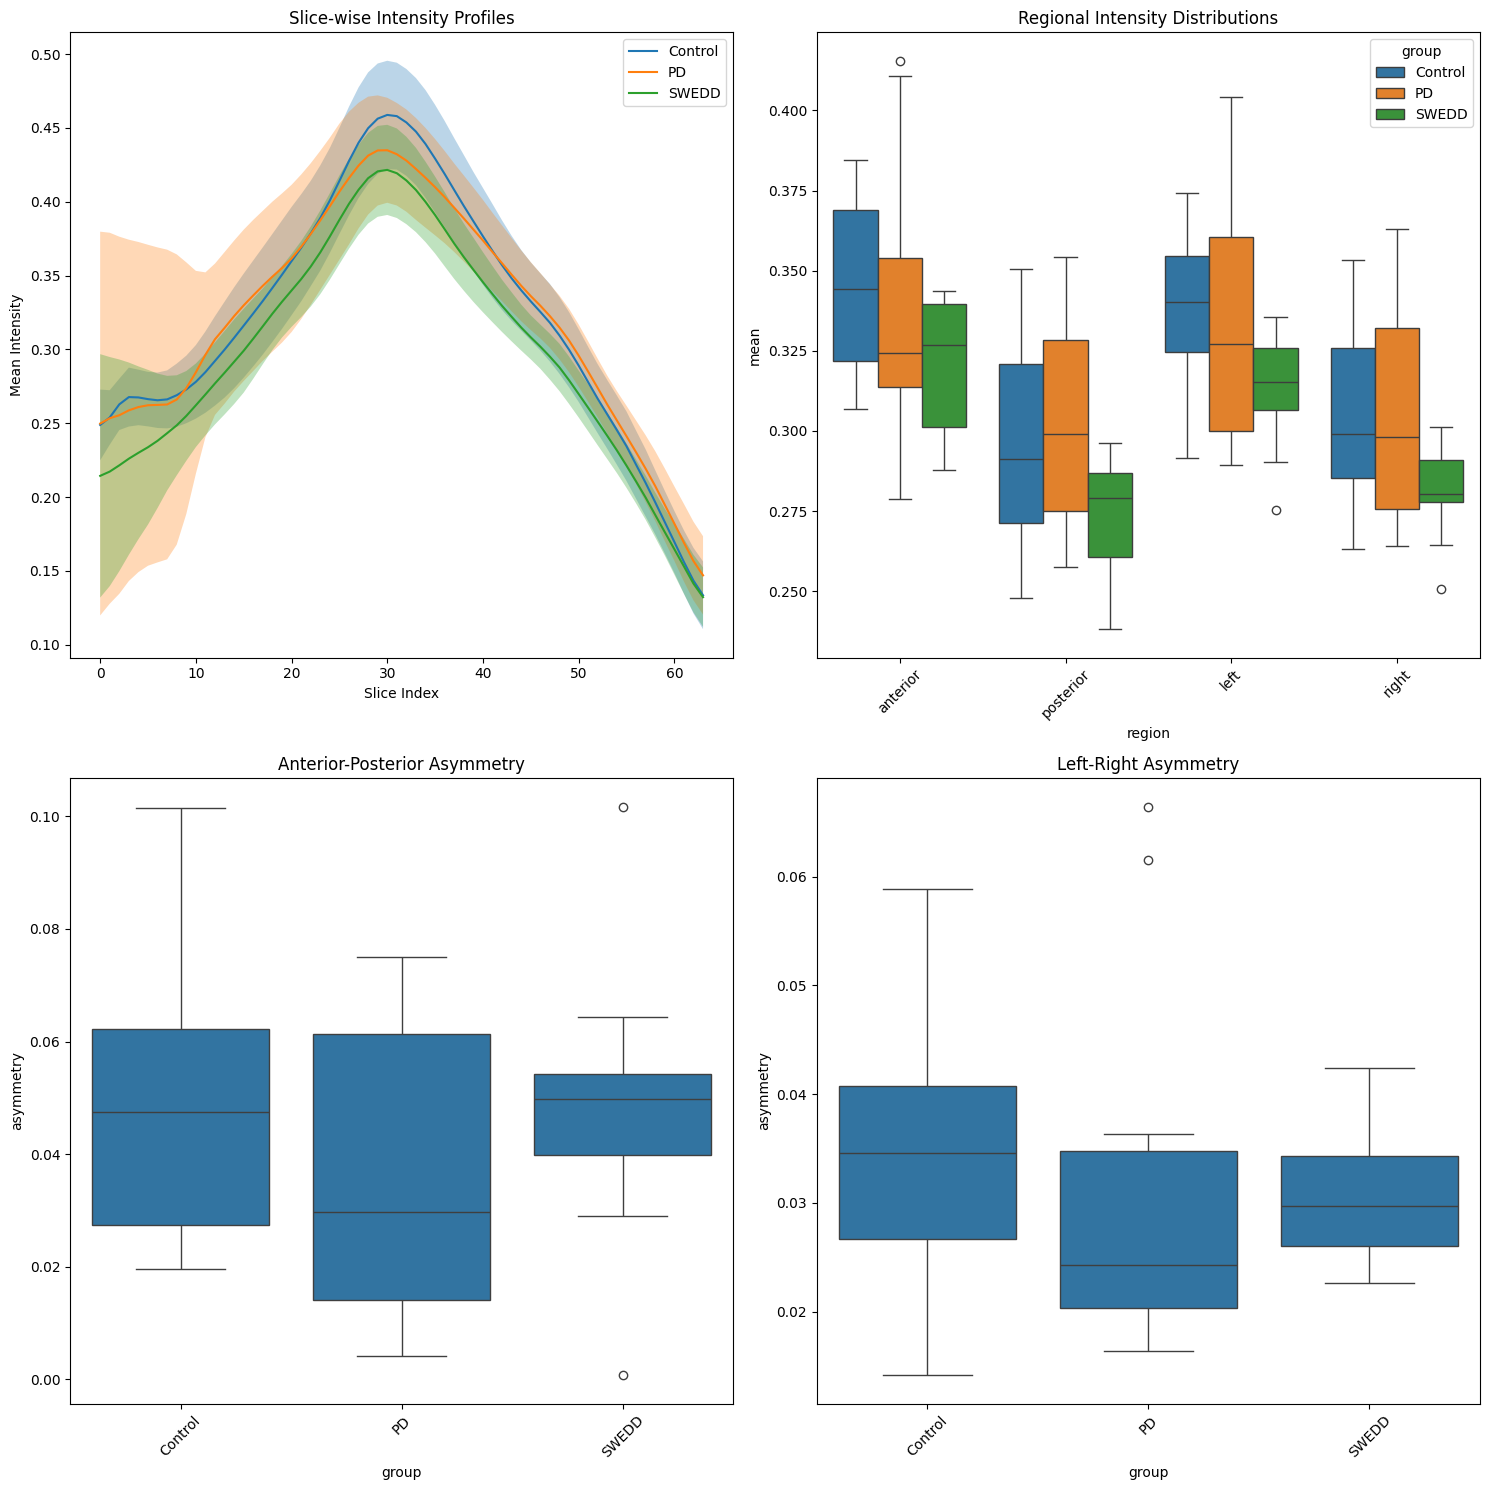


Regional Statistics Summary:
                    mean    std
group   region                 
Control anterior   0.346  0.028
        left       0.337  0.026
        posterior  0.295  0.033
        right      0.303  0.029
PD      anterior   0.338  0.045
        left       0.336  0.042
        posterior  0.302  0.034
        right      0.304  0.035
SWEDD   anterior   0.321  0.022
        left       0.312  0.018
        posterior  0.273  0.020
        right      0.281  0.016


In [15]:
# Cell 12: Spatial Pattern Analysis
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_spatial_patterns(df, num_samples_per_group=10):
    """
    Analyzes spatial patterns in the volumes:
    1. Slice-wise intensity profiles
    2. Regional intensity variations
    3. Group-wise spatial differences
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize collectors
    slice_profiles = {group: [] for group in ['Control', 'PD', 'SWEDD']}
    regional_stats = {group: [] for group in ['Control', 'PD', 'SWEDD']}
    
    for group in ['Control', 'PD', 'SWEDD']:
        group_df = df[df['label'] == group]
        samples = group_df.sample(n=min(num_samples_per_group, len(group_df)))
        
        for _, row in tqdm(samples.iterrows(), desc=f"Processing {group}"):
            volume_tensor, _ = load_dicom(row['file_path'], device)
            if volume_tensor is None:
                continue
                
            # Process volume
            norm_vol, mask, masked_vol = process_volume(
                volume_tensor[9:73],
                target_shape=(64, 128, 128),
                device=device
            )
            
            # 1. Slice-wise profile
            slice_means = torch.mean(masked_vol, dim=(1,2)).cpu().numpy()
            slice_profiles[group].append(slice_means)
            
            # 2. Regional analysis
            # Define regions (anterior, posterior, left, right)
            regions = {
                'anterior': masked_vol[:, :64, :],
                'posterior': masked_vol[:, 64:, :],
                'left': masked_vol[:, :, :64],
                'right': masked_vol[:, :, 64:]
            }
            
            stats = {f"{region}_{stat}": value.item() 
                    for region, tensor in regions.items()
                    for stat, value in {
                        'mean': tensor.mean(),
                        'std': tensor.std()
                    }.items()}
            regional_stats[group].append(stats)
            
            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Plotting
    plt.figure(figsize=(15, 15))
    
    # Plot 1: Slice-wise intensity profiles
    plt.subplot(221)
    for group in slice_profiles:
        profiles = np.array(slice_profiles[group])
        mean_profile = np.mean(profiles, axis=0)
        std_profile = np.std(profiles, axis=0)
        x = np.arange(len(mean_profile))
        plt.plot(x, mean_profile, label=group)
        plt.fill_between(x, mean_profile-std_profile, mean_profile+std_profile, alpha=0.3)
    plt.title('Slice-wise Intensity Profiles')
    plt.xlabel('Slice Index')
    plt.ylabel('Mean Intensity')
    plt.legend()
    
    # Plot 2: Regional comparisons
    plt.subplot(222)
    regional_data = []
    for group in regional_stats:
        for stats in regional_stats[group]:
            for region in ['anterior', 'posterior', 'left', 'right']:
                regional_data.append({
                    'group': group,
                    'region': region,
                    'mean': stats[f'{region}_mean']
                })
    regional_df = pd.DataFrame(regional_data)
    sns.boxplot(data=regional_df, x='region', y='mean', hue='group')
    plt.title('Regional Intensity Distributions')
    plt.xticks(rotation=45)
    
    # Plot 3: Anterior-Posterior asymmetry
    plt.subplot(223)
    asymmetry_data = []
    for group in regional_stats:
        for stats in regional_stats[group]:
            asymmetry = stats['anterior_mean'] - stats['posterior_mean']
            asymmetry_data.append({'group': group, 'asymmetry': asymmetry})
    asymmetry_df = pd.DataFrame(asymmetry_data)
    sns.boxplot(data=asymmetry_df, x='group', y='asymmetry')
    plt.title('Anterior-Posterior Asymmetry')
    plt.xticks(rotation=45)
    
    # Plot 4: Left-Right asymmetry
    plt.subplot(224)
    lr_asymmetry_data = []
    for group in regional_stats:
        for stats in regional_stats[group]:
            asymmetry = stats['left_mean'] - stats['right_mean']
            lr_asymmetry_data.append({'group': group, 'asymmetry': asymmetry})
    lr_asymmetry_df = pd.DataFrame(lr_asymmetry_data)
    sns.boxplot(data=lr_asymmetry_df, x='group', y='asymmetry')
    plt.title('Left-Right Asymmetry')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nRegional Statistics Summary:")
    regional_df_summary = regional_df.groupby(['group', 'region'])['mean'].agg(['mean', 'std']).round(3)
    print(regional_df_summary)
    
    return slice_profiles, regional_stats

# Run analysis
spatial_profiles, regional_statistics = analyze_spatial_patterns(df)

Processing Control: 30it [00:03,  8.71it/s]
Processing PD: 30it [00:03,  8.25it/s]
Processing SWEDD: 30it [00:03,  8.93it/s]


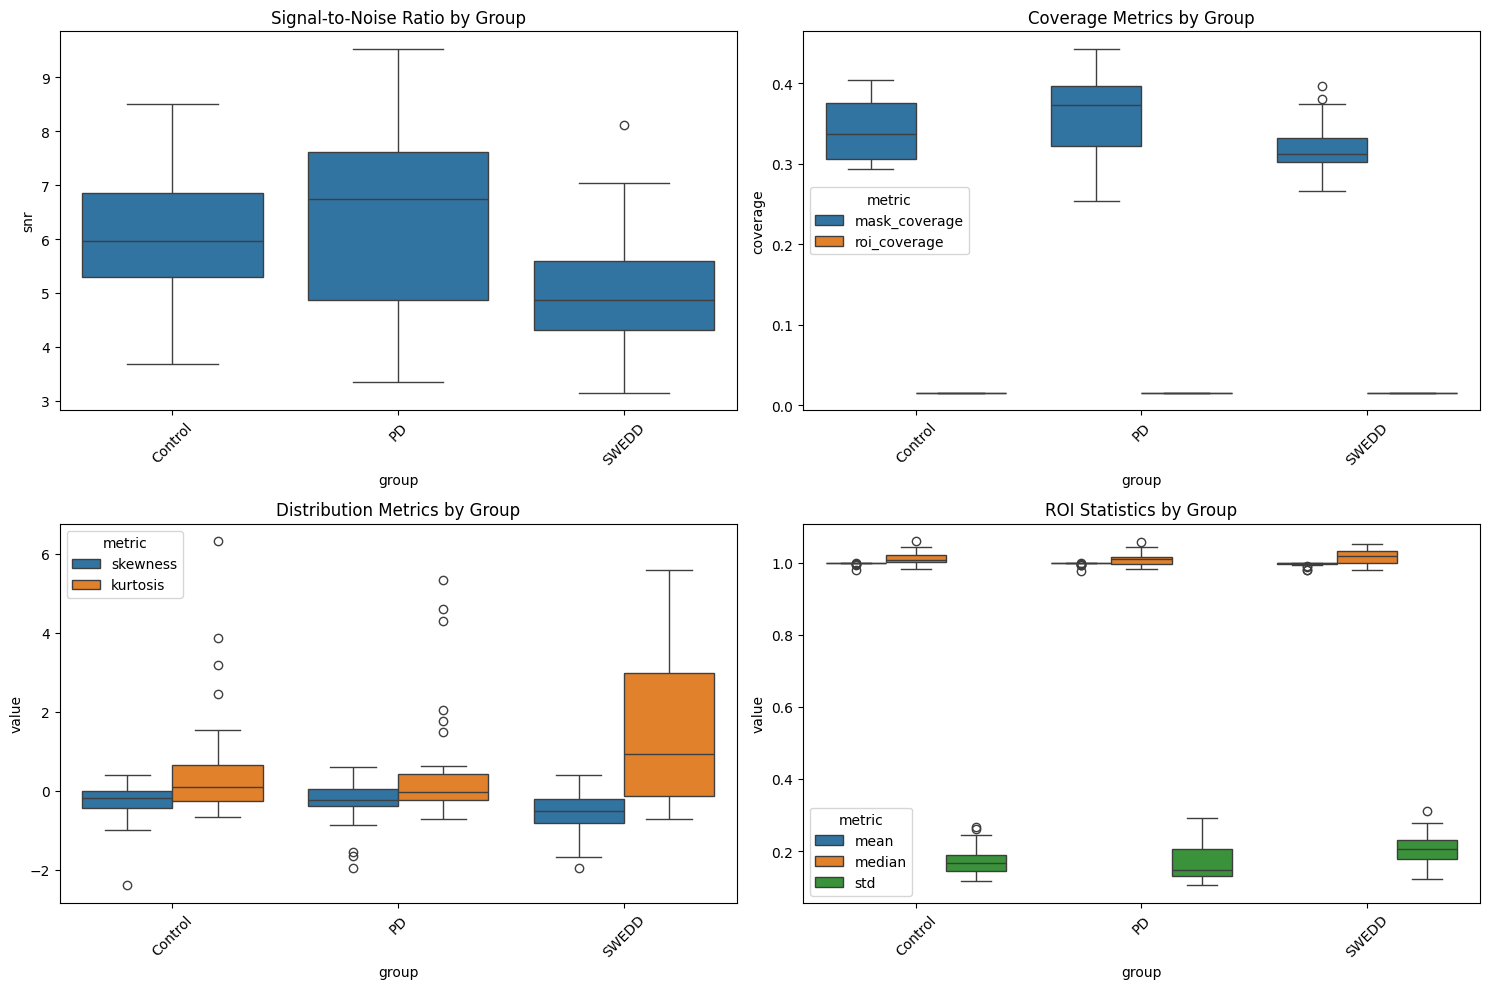

=== Summary Statistics by Group ===

Control Statistics:
         mean  median     std  skewness  kurtosis      q1      q3  \
count  30.000  30.000  30.000    30.000    30.000  30.000  30.000   
mean    0.999   1.011   0.174    -0.298     0.593   0.882   1.119   
std     0.004   0.016   0.038     0.538     1.529   0.033   0.026   
min     0.980   0.983   0.118    -2.401    -0.672   0.787   1.078   
25%     0.999   1.002   0.146    -0.442    -0.252   0.867   1.100   
50%     1.000   1.008   0.168    -0.185     0.089   0.890   1.119   
75%     1.000   1.021   0.189    -0.006     0.656   0.902   1.127   
max     1.000   1.060   0.266     0.396     6.327   0.933   1.191   

       mask_coverage  roi_coverage  
count         30.000        30.000  
mean           0.340         0.016  
std            0.035         0.000  
min            0.294         0.016  
25%            0.306         0.016  
50%            0.337         0.016  
75%            0.376         0.016  
max            0.403     

In [16]:
# Cell 13: Comprehensive Summary Statistics
import torch
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_summary_statistics(df, num_samples_per_group=30):
    """
    Generates comprehensive summary statistics for the dataset:
    1. Group-wise statistics
    2. ROI analysis
    3. Statistical tests between groups
    4. Quality metrics
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Data collectors
    group_stats = {group: [] for group in ['Control', 'PD', 'SWEDD']}
    quality_metrics = []
    
    # Process samples
    for group in ['Control', 'PD', 'SWEDD']:
        group_df = df[df['label'] == group]
        samples = group_df.sample(n=min(num_samples_per_group, len(group_df)))
        
        for _, row in tqdm(samples.iterrows(), desc=f"Processing {group}"):
            volume_tensor, _ = load_dicom(row['file_path'], device)
            if volume_tensor is None:
                continue
                
            # Process volume
            norm_vol, mask, masked_vol = process_volume(
                volume_tensor[9:73],
                target_shape=(64, 128, 128),
                device=device
            )
            
            # ROI analysis
            roi_mask = torch.zeros_like(norm_vol, device=device)
            roi_mask[20:40, 82:103, 43:82] = 1
            roi_values = masked_vol[roi_mask.bool()]
            
            # Convert to numpy for statistics
            roi_numpy = roi_values.cpu().numpy()
            
            # Calculate statistics
            stats_dict = {
                'mean': roi_values.mean().item(),
                'median': roi_values.median().item(),
                'std': roi_values.std().item(),
                'skewness': scipy_stats.skew(roi_numpy),
                'kurtosis': scipy_stats.kurtosis(roi_numpy),
                'q1': np.percentile(roi_numpy, 25),
                'q3': np.percentile(roi_numpy, 75),
                'mask_coverage': (mask.sum() / mask.numel()).item(),
                'roi_coverage': (roi_mask.sum() / roi_mask.numel()).item()
            }
            
            group_stats[group].append(stats_dict)
            
            # Quality metrics
            quality_metrics.append({
                'group': group,
                'file': row['file_path'],
                'snr': (roi_values.mean() / roi_values.std()).item(),
                'mask_coverage': stats_dict['mask_coverage'],
                'roi_coverage': stats_dict['roi_coverage']
            })
            
            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Convert to DataFrames
    stats_dfs = {group: pd.DataFrame(stats) for group, stats in group_stats.items()}
    quality_df = pd.DataFrame(quality_metrics)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: SNR Distribution
    plt.subplot(221)
    sns.boxplot(data=quality_df, x='group', y='snr')
    plt.title('Signal-to-Noise Ratio by Group')
    plt.xticks(rotation=45)
    
    # Plot 2: Coverage Metrics
    plt.subplot(222)
    coverage_data = pd.melt(quality_df, 
                           id_vars=['group'], 
                           value_vars=['mask_coverage', 'roi_coverage'],
                           var_name='metric', value_name='coverage')
    sns.boxplot(data=coverage_data, x='group', y='coverage', hue='metric')
    plt.title('Coverage Metrics by Group')
    plt.xticks(rotation=45)
    
    # Plot 3: Distribution Metrics
    plt.subplot(223)
    dist_data = []
    for group, stats in group_stats.items():
        for s in stats:
            dist_data.extend([
                {'group': group, 'metric': 'skewness', 'value': s['skewness']},
                {'group': group, 'metric': 'kurtosis', 'value': s['kurtosis']}
            ])
    dist_df = pd.DataFrame(dist_data)
    sns.boxplot(data=dist_df, x='group', y='value', hue='metric')
    plt.title('Distribution Metrics by Group')
    plt.xticks(rotation=45)
    
    # Plot 4: ROI Statistics
    plt.subplot(224)
    roi_data = []
    for group, stats in group_stats.items():
        for s in stats:
            roi_data.extend([
                {'group': group, 'metric': 'mean', 'value': s['mean']},
                {'group': group, 'metric': 'median', 'value': s['median']},
                {'group': group, 'metric': 'std', 'value': s['std']}
            ])
    roi_df = pd.DataFrame(roi_data)
    sns.boxplot(data=roi_df, x='group', y='value', hue='metric')
    plt.title('ROI Statistics by Group')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary reports
    print("=== Summary Statistics by Group ===")
    for group, df in stats_dfs.items():
        print(f"\n{group} Statistics:")
        print(df.describe().round(3))
    
    print("\n=== Quality Metrics ===")
    print(quality_df.groupby('group').agg({
        'snr': ['mean', 'std'],
        'mask_coverage': ['mean', 'std'],
        'roi_coverage': ['mean', 'std']
    }).round(3))
    
    # Perform statistical tests
    print("\n=== Statistical Tests ===")
    # Extract mean values for each group
    control_means = [s['mean'] for s in group_stats['Control']]
    pd_means = [s['mean'] for s in group_stats['PD']]
    swedd_means = [s['mean'] for s in group_stats['SWEDD']]
    
    # Perform one-way ANOVA
    f_stat, p_val = scipy_stats.f_oneway(control_means, pd_means, swedd_means)
    print(f"One-way ANOVA: F-statistic = {f_stat:.3f}, p-value = {p_val:.3f}")
    
    # Perform pairwise t-tests with Bonferroni correction
    alpha = 0.05 / 3  # Bonferroni correction for 3 comparisons
    print("\nPairwise t-tests (Bonferroni-corrected α = {:.3f}):".format(alpha))
    
    # Control vs PD
    t_stat, p_val = scipy_stats.ttest_ind(control_means, pd_means)
    print(f"Control vs PD: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")
    
    # Control vs SWEDD
    t_stat, p_val = scipy_stats.ttest_ind(control_means, swedd_means)
    print(f"Control vs SWEDD: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")
    
    # PD vs SWEDD
    t_stat, p_val = scipy_stats.ttest_ind(pd_means, swedd_means)
    print(f"PD vs SWEDD: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")
    
    return stats_dfs, quality_df

# Run analysis
df = pd.read_csv("validated_file_paths.csv")
stats_dataframes, quality_metrics = generate_summary_statistics(df)

Processing Control: 0it [00:00, ?it/s]

Processing Control: 30it [00:03,  9.79it/s]
Processing PD: 30it [00:03,  9.36it/s]
Processing SWEDD: 30it [00:02, 10.15it/s]


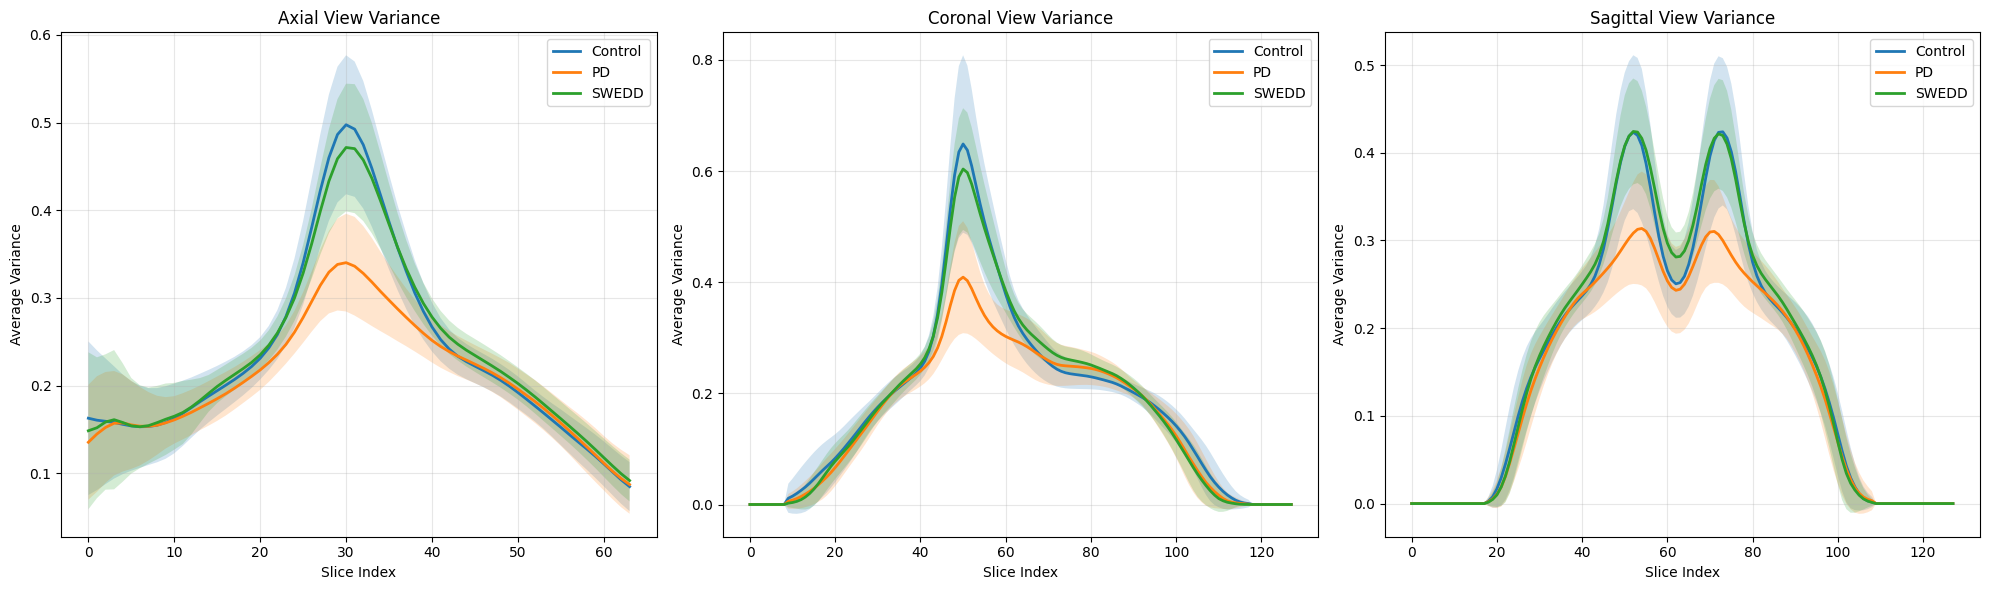


Average Variance by Group and View:

Axial View:
Control: 0.236 (±0.116)
PD: 0.209 (±0.075)
SWEDD: 0.238 (±0.108)

Coronal View:
Control: 0.184 (±0.170)
PD: 0.158 (±0.129)
SWEDD: 0.181 (±0.166)

Sagittal View:
Control: 0.160 (±0.152)
PD: 0.140 (±0.126)
SWEDD: 0.164 (±0.154)


In [17]:
# Cell 14: Slice-wise Variance Analysis Across Views
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def analyze_slice_variance(df, num_samples_per_group=30):
    """
    Analyzes slice-wise variance across axial, coronal, and sagittal views.
    Compares variance patterns between Control, PD, and SWEDD groups.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Data collectors for each view and group
    variance_data = {
        'axial': {group: [] for group in ['Control', 'PD', 'SWEDD']},
        'coronal': {group: [] for group in ['Control', 'PD', 'SWEDD']},
        'sagittal': {group: [] for group in ['Control', 'PD', 'SWEDD']}
    }
    
    # Process samples for each group
    for group in ['Control', 'PD', 'SWEDD']:
        group_df = df[df['label'] == group]
        samples = group_df.sample(n=min(num_samples_per_group, len(group_df)))
        
        for _, row in tqdm(samples.iterrows(), desc=f"Processing {group}"):
            volume_tensor, _ = load_dicom(row['file_path'], device)
            if volume_tensor is None:
                continue
                
            # Process volume
            norm_vol, mask, masked_vol = process_volume(
                volume_tensor[9:73],
                target_shape=(64, 128, 128),
                device=device
            )
            
            # Calculate variance for each slice in each view
            # Axial view (top to bottom)
            axial_var = torch.var(masked_vol, dim=(1,2)).cpu().numpy()  # Variance across each axial slice
            variance_data['axial'][group].append(axial_var)
            
            # Coronal view (front to back)
            coronal_var = torch.var(masked_vol, dim=(0,2)).cpu().numpy()  # Variance across each coronal slice
            variance_data['coronal'][group].append(coronal_var)
            
            # Sagittal view (left to right)
            sagittal_var = torch.var(masked_vol, dim=(0,1)).cpu().numpy()  # Variance across each sagittal slice
            variance_data['sagittal'][group].append(sagittal_var)
            
            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Calculate mean and std for each group and view
    plt.figure(figsize=(20, 6))
    views = ['axial', 'coronal', 'sagittal']
    
    for idx, view in enumerate(views, 1):
        plt.subplot(1, 3, idx)
        
        for group in ['Control', 'PD', 'SWEDD']:
            # Stack all samples for this group and view
            all_samples = np.stack(variance_data[view][group])
            
            # Calculate mean and std across samples
            mean_var = np.mean(all_samples, axis=0)
            std_var = np.std(all_samples, axis=0)
            
            # Create x-axis based on number of slices
            x = np.arange(len(mean_var))
            
            # Plot mean line and confidence interval
            plt.plot(x, mean_var, label=group, linewidth=2)
            plt.fill_between(x, mean_var - std_var, mean_var + std_var, alpha=0.2)
        
        plt.title(f'{view.capitalize()} View Variance')
        plt.xlabel('Slice Index')
        plt.ylabel('Average Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nAverage Variance by Group and View:")
    for view in views:
        print(f"\n{view.capitalize()} View:")
        for group in ['Control', 'PD', 'SWEDD']:
            all_samples = np.stack(variance_data[view][group])
            mean_total = np.mean(all_samples)
            std_total = np.std(all_samples)
            print(f"{group}: {mean_total:.3f} (±{std_total:.3f})")
    
    return variance_data

# Run analysis
df = pd.read_csv("validated_file_paths.csv")
slice_variance_data = analyze_slice_variance(df)

# Model

## Autoencoder

### Slice Intensity Variance Analysis

In [19]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")

    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}

    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']

            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()

                if sample_counts[label] >= num_samples_per_group:
                    continue

                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape

                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]

                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)

                sample_counts[label] += 1

            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0)
            for view, variances in group_variances[group].items()
        }

    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, view in enumerate(views):
        ax = axes[idx]

        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)

        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   0%|          | 0/35 [00:00<?, ?it/s]


Plotting slice-wise variance analysis...


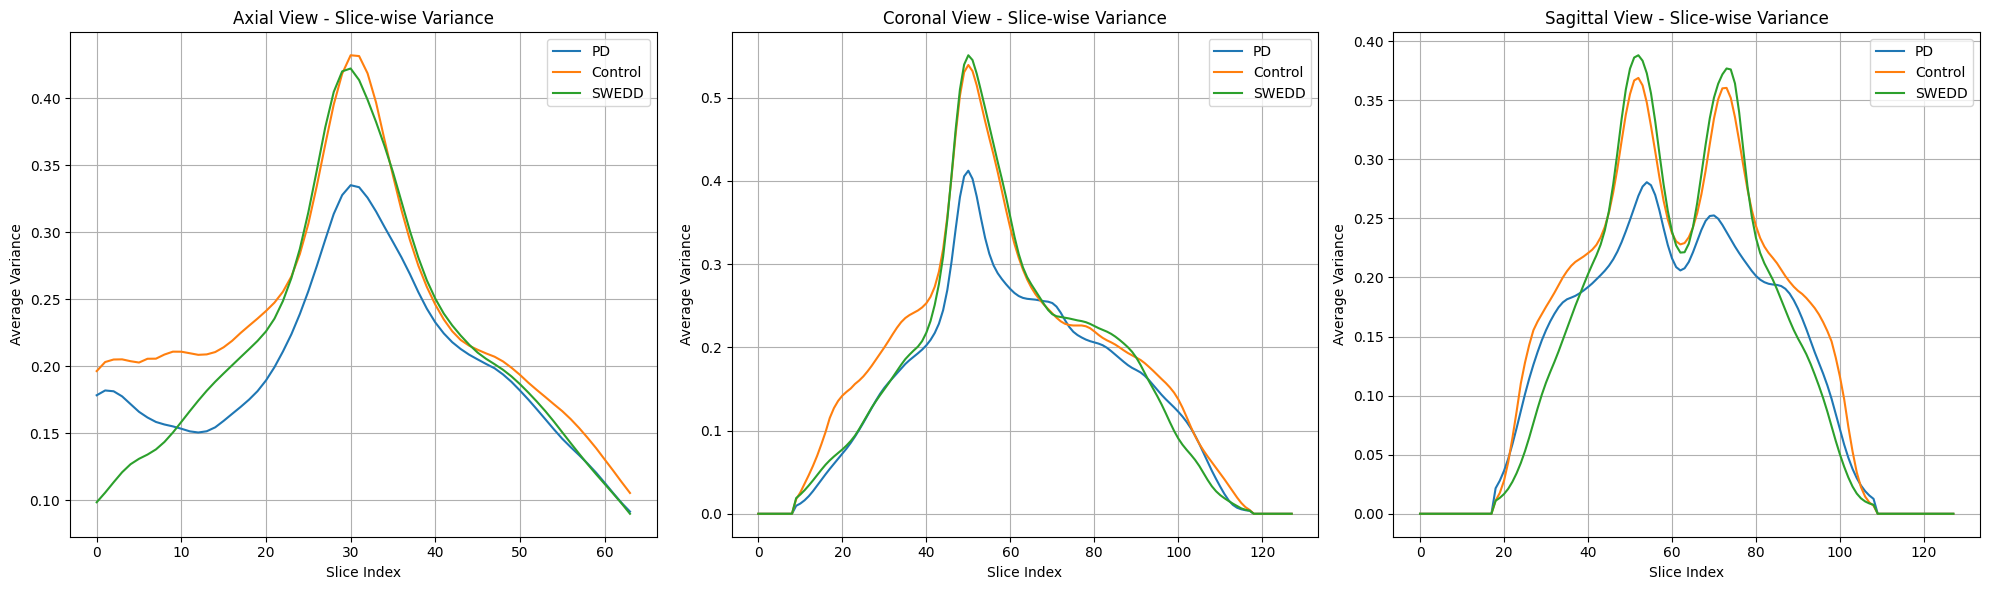

In [20]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)

# Model Phase

## 1. Autoencoder